In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers.models.llama.modeling_llama import LlamaAttention, LlamaMLP, LlamaDecoderLayer, LlamaRMSNorm
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding
from transformers.models.gpt2.modeling_gpt2 import GPT2Block, GPT2Attention
from transformers import AutoTokenizer
from tqdm import tqdm
import torch as torch
import torch.nn as nn
from scipy.stats import gaussian_kde
import math
import pickle
from modular_transformers.straightening.straightening_utils import (
    compute_model_activations,
    compute_model_curvature,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hf_auth_token = "" #REPLACE_WITH_YOUR_HUGGINGFACE_TOKEN

In [2]:
def init_qk_weights(param, attention_sigma):
    variance = attention_sigma / param.shape[0]
    nn.init.normal_(param, 0, np.sqrt(variance))

def init_v_weights(param):
    nn.init.normal_(param, 0, np.sqrt(1/param.shape[0]))

def initialize_gpt2_qk_weights(module, attention_sigma):
    """
    Initialize the Q, K parts of GPT-2's attention matrices separately.
    
    Args:
        model: The GPT-2 model
    """
    for name, submodule in module.named_modules():
        if isinstance(submodule, GPT2Attention):
            # Get the c_attn weight matrix
            weight = submodule.c_attn.weight
            # Get the dimensions
            split_size = submodule.split_size  # This should be equal to hidden_size

            q_weight, k_weight, v_weight = weight.split(split_size, dim=1)
            
            # Initialize each part separately
            init_qk_weights(q_weight, attention_sigma)
            init_qk_weights(k_weight, attention_sigma)
            init_v_weights(v_weight)

def initialize_weights(module, distribution, attention_sigma, mlp_sigma):
    for name, param in module.named_parameters():
        if "v_proj" in name or "o_proj" in name or "c_proj" in name:
            nn.init.normal_(param, 0, np.sqrt(1/param.shape[0]))
        elif "bias" in name:
            nn.init.zeros_(param)
        elif "layernorm" in name or "ln" in name:
            # Set weight (scale) to identity
            nn.init.ones_(param)  # LayerNorm typically uses ones initialization
            # Set bias to 0
            if hasattr(module, 'bias') and module.bias is not None:
                nn.init.zeros_(module.bias)
        else:
            if "q_proj" in name or "k_proj" in name:
                variance = attention_sigma / param.shape[0]
            else:
                variance = mlp_sigma**2 / param.shape[0]

            if distribution == "uniform":
                width = np.sqrt(variance * 12) / 2
                nn.init.uniform_(param, -width, width)
            elif distribution == "normal":
                nn.init.normal_(param, 0, np.sqrt(variance))


# Single Layer Test

In [3]:
def layer_norm(input):
    return math.sqrt(input.shape[-1]) * input / torch.norm(input, dim=-1, keepdim=True)

def forward_pass(attention, mlp, input, position_ids):
    mlp.eval()
    attention.eval()
    residual = input
    with torch.no_grad():
        hidden_state = layer_norm(residual)
        attention_output = attention(hidden_state, position_ids=position_ids)[0]
        residual = attention_output + residual
        hidden_state = layer_norm(residual)
        mlp_output = mlp(hidden_state)[0]
    return mlp_output + residual

def generate_input(n, d, correlation):
    # Generate the "tokens" as described in the paper 

    # Step 1: Generate base vectors
    # Generate n independent Gaussian vectors of dimension d
    independent_vectors = np.random.normal(size=(n, d))

    # Step 2: Create correlation matrix and get Cholesky decomposition
    correlation_matrix = np.full((n, n), correlation)
    np.fill_diagonal(correlation_matrix, 1.0)
    L = np.linalg.cholesky(correlation_matrix)

    # Step 3: Apply Cholesky factor to correlate vectors
    # `correlated_vectors` now has the desired correlations across vectors
    input = L @ independent_vectors  # Shape: (n, d)

    input = torch.tensor(input, dtype=torch.float32)

    input = input.unsqueeze(0)

    return input

# def generate_input(n, d, correlation):
#     return np.random.normal(size=(n, d))

def calculate_pq(input):
    # Compute dot product matrix
    dot_product_matrix = input @ input.T

    # Extract norms (diagonal) and average norm
    q = np.mean(np.diag(dot_product_matrix))

    # Extract dot products (off-diagonal) and average dot product
    p = np.mean(dot_product_matrix[np.triu_indices(len(input), k=1)])
    
    return p, q

def calculate_lyapunov_exponent(p, q, p_prime, q_prime):
    numerator = 1 - p_prime/q_prime
    denominator = 1 - p/q
    return np.log(numerator/denominator)

def calculate_curvature(model, data, device):
    activations = compute_model_activations(model, data, device)
    curves = np.array(compute_model_curvature(activations)["all_layer_curve_all"])
    return curves

def compute_gradient_exponent(last_hidden_state, L):
    """
    Given a model and input_tokens (of shape [n, d]), compute the gradient exponent.
    The gradient exponent is defined as:
        lambda_g = (1/L) * log( ||∇_{X_0}(X_L⋅R)||^2 )
    where L is the number of layers.
    """
    # Create a random probe tensor R with the same shape as the output.
    R = torch.randn_like(last_hidden_state)

    # Compute a scalar by dotting the output with R.
    scalar = (last_hidden_state * R).sum()

    # Compute gradient of the scalar with respect to the input tokens.
    grad = torch.autograd.grad(scalar, last_hidden_state, create_graph=True)[0]
    grad_norm_sq = grad.pow(2).sum()  # squared Frobenius norm

    # Compute per-layer gradient exponent.
    lambda_g = (1.0 / L) * torch.log(grad_norm_sq)

    return lambda_g.item(), grad_norm_sq.item()
    

## Lyapunov exponent over one layer

In [7]:
model_name = "meta-llama/Llama-2-7b-hf" 
activation_function = "tanh" #from paper
# activation_function = "silu" #Llama default, raises the variance for lambda=0 significantly
config = AutoConfig.from_pretrained(model_name, token=hf_auth_token)
n = 64 #not sure how to choose this (256 in paper), but doesn't seem to have a huge effect
d = config.hidden_size
correlation = 0.99
attention_sigma = 0.1 #not sure how to choose this but doesn't seem to have a huge effect
position_ids = torch.arange(0, n).unsqueeze(0).to(device)

config.hidden_act = activation_function
attention = LlamaAttention(config, layer_idx=1).to(device)
mlp = LlamaMLP(config).to(device)

mlp_sigmas = np.arange(0, 10, 0.01)
lyapunov_exponents = []

for mlp_sigma in tqdm(mlp_sigmas):
    initialize_weights(attention, "normal", attention_sigma, mlp_sigma)
    initialize_weights(mlp, "normal", attention_sigma, mlp_sigma)

    # Generate input
    input = generate_input(n, d, correlation).to(device)

    # Forward pass
    output = forward_pass(attention, mlp, input, position_ids)[0]
    p, q = calculate_pq(input.cpu().numpy().squeeze())
    p_prime, q_prime = calculate_pq(output.cpu().numpy().squeeze())

    # Calculate Lyapunov exponent
    lyapunov_exponent = calculate_lyapunov_exponent(p, q, p_prime, q_prime)
    lyapunov_exponents.append(lyapunov_exponent)

100%|██████████| 1000/1000 [00:22<00:00, 45.13it/s]


In [ ]:
plt.plot(mlp_sigmas, lyapunov_exponents)
#put a vertical line at the point where the lyapunov exponent is 0
plt.axvline(x=mlp_sigmas[np.argmin(np.abs(lyapunov_exponents))], color='r', linestyle='--', label=r"$\lambda_a = 0$")
plt.hlines(0, 0, 10, colors='r', linestyles='--')
plt.xlabel(r"MLP Variance ($\sigma_w$)")
plt.ylabel(r"Lyapunov Exponent ($\lambda_a$)")
plt.title(r"Lyapunov Exponent vs MLP Variance in One Llama Layer")
plt.legend()
plt.show()

# Full Model Test

In [3]:
class PaperNorm(nn.Module):
    def __init__(self, hidden_size, eps=None):
        super().__init__()
        self.hidden_size = hidden_size
    
    def forward(self, input):
        return math.sqrt(self.hidden_size) * input / torch.norm(input, dim=-1, keepdim=True)

class StrippedLlama(nn.Module):
    def __init__(self, config, norm_func):
        super().__init__()
        self.config = config
        
        if norm_func == "rms":
            self.norm_func = LlamaRMSNorm
        elif norm_func == "layernorm":
            self.norm_func = nn.LayerNorm
        else:
            self.norm_func = PaperNorm
        
        # Initialize rotary embeddings
        self.rotary_emb = LlamaRotaryEmbedding(config)
        self.token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)

        self.layers = nn.ModuleList(
            [LlamaDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )

        self.post_init()
    
    def post_init(self):
        for layer in self.layers:
            layer.input_layernorm = self.norm_func(self.config.hidden_size, eps=self.config.rms_norm_eps)
            layer.post_attention_layernorm = self.norm_func(self.config.hidden_size, eps=self.config.rms_norm_eps)
    
    def initialize_weights(self, attention_sigma, mlp_sigma):
        for layer in self.layers:
            initialize_weights(layer, "normal", attention_sigma, mlp_sigma)
    
    def forward(self, input, input_is_tokens=True, position_ids=None, output_hidden_states=False, output_attentions=False, use_position_embeddings=True):
        if position_ids is None:
            position_ids = torch.arange(0, input.shape[1]).unsqueeze(0).to(input.device)
        position_embeddings = self.rotary_emb(input, position_ids)
        if not use_position_embeddings:
            new_cos = torch.ones_like(position_embeddings[0])
            new_sin = torch.zeros_like(position_embeddings[0])
            position_embeddings = (new_cos, new_sin)

        #if we want to use positional embeddings, I think we need to add them to hidden state
        if input_is_tokens:
            hidden_state = self.token_embedding(input)
        else:
            hidden_state = input

        hidden_states = []
        for layer in self.layers:
            hidden_state = layer(hidden_state, position_ids=position_ids, position_embeddings=position_embeddings)[0]
            hidden_states.append(hidden_state)
        if output_hidden_states:
            return {"last_hidden_state": hidden_state, "hidden_states": torch.stack(hidden_states).detach()}
        else:
            return hidden_state

class StrippedGPT2(nn.Module):
    def __init__(self, config, norm_func):
        super().__init__()
        self.config = config
        
        if norm_func == "layernorm":
            self.norm_func = nn.LayerNorm
        else:
            self.norm_func = PaperNorm
        
        self.position_embedding = nn.Embedding(config.n_positions, config.hidden_size)
        self.token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)

        self.layers = nn.ModuleList(
            [GPT2Block(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )

        self.post_init()
    
    def post_init(self):
        for layer in self.layers:
            layer.ln_1 = self.norm_func(self.config.hidden_size)
            layer.ln_2 = self.norm_func(self.config.hidden_size)
    
    def initialize_weights(self, attention_sigma, mlp_sigma):
        for layer in self.layers:
            initialize_weights(layer, "normal", attention_sigma, mlp_sigma)
            initialize_gpt2_qk_weights(layer, attention_sigma)
    
    def forward(self, input, output_hidden_states=False, input_is_tokens=False, output_attentions=False, use_position_embeddings=False):
        hidden_states = []
        #if we want to use positional embeddings, I think we need to add them to hidden state
        if input_is_tokens:
            hidden_state = self.token_embedding(input)
        else:
            hidden_state = input
        if use_position_embeddings:
            position_ids = torch.arange(0, input.shape[1]).unsqueeze(0).to(input.device)
            position_embeddings = self.position_embedding(position_ids)
            hidden_state = hidden_state + position_embeddings

        for layer in self.layers:
            hidden_state = layer(hidden_state)[0]
            hidden_states.append(hidden_state.squeeze(0).detach().cpu().numpy())
        if output_hidden_states:
            return {"last_hidden_state": hidden_state, "hidden_states": hidden_states}
        else:
            return hidden_state

In [24]:
#Define the model parameters

model_name = "meta-llama/Llama-2-7b-hf" 
# model_name = "gpt2"
config = AutoConfig.from_pretrained(model_name, token=hf_auth_token)

activation_function = "tanh" #from paper (silu is llama default)
n = 64 #input size
d = config.hidden_size
num_layers = config.num_hidden_layers
config.n_positions = 64
norm_func = "paper"

config.num_hidden_layers = 12
config.hidden_size = 768
d = config.hidden_size

correlation = 0.99
attention_sigma = 1

config.hidden_act = activation_function

if model_name == "meta-llama/Llama-2-7b-hf":
    model = StrippedLlama(config, norm_func).to(device)
elif model_name == "gpt2":
    model = StrippedGPT2(config, norm_func).to(device)

In [25]:
#prepare data for calculating curvature
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_auth_token)
CURVATURE_DATA_PATH = (
    "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/"
    "generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
)
with open(CURVATURE_DATA_PATH, "rb") as f:
    raw_data = pickle.load(f)
sentences = tokenizer.batch_encode_plus(
    raw_data, add_special_tokens=True, padding=False
)["input_ids"]
# Only keep sentences longer than 14 tokens and truncate to 14 tokens
data = [torch.tensor(s) for s in sentences if len(s) > 14]
data = torch.stack([s[:14] for s in data])
#sample 100 sentences
data = data[:100]

## Lyapunov exponent over full model

In [26]:
mlp_sigmas = np.arange(0, 10, 0.5)
attention_sigmas = np.arange(0, 10, 0.5)
lyapunov_exponents = np.zeros((len(mlp_sigmas), len(attention_sigmas)))
curves = np.zeros((len(mlp_sigmas), len(attention_sigmas)))
gradient_exponents = np.zeros((len(mlp_sigmas), len(attention_sigmas)))

# Generate input
input = generate_input(n, d, correlation).to(device)
p, q = calculate_pq(input.cpu().numpy().squeeze())
input.requires_grad_()

for mlp_sigma_idx, mlp_sigma in tqdm(enumerate(mlp_sigmas)):
    for attention_sigma_idx, attention_sigma in enumerate(attention_sigmas):    
        model.initialize_weights(attention_sigma, mlp_sigma)
        output = model(input, input_is_tokens=False, use_position_embeddings=False)
        # curvature = np.mean(calculate_curvature(model, data, device)) * 180 / np.pi
        # curves[mlp_sigma_idx, attention_sigma_idx] = curvature

        p_prime, q_prime = calculate_pq(output.detach().cpu().numpy().squeeze())
        # Calculate Lyapunov exponent
        lyapunov_exponent = calculate_lyapunov_exponent(p, q, p_prime, q_prime)
        lyapunov_exponents[mlp_sigma_idx, attention_sigma_idx] = lyapunov_exponent

        gradient_exponent = compute_gradient_exponent(output, model.config.num_hidden_layers)[0]
        gradient_exponents[mlp_sigma_idx, attention_sigma_idx] = gradient_exponent


0it [00:00, ?it/s]

20it [00:05,  3.38it/s]


## norms and angles over every layer in model

In [15]:
mlp_sigmas = [1, 2, 4]

num_runs = 100
token_norms = np.zeros((num_runs, num_layers, len(mlp_sigmas)))
token_angles = np.zeros((num_runs, num_layers, len(mlp_sigmas)))
model.eval()

for variance_idx, mlp_sigma in tqdm(enumerate(mlp_sigmas)):
    model.initialize_weights(attention_sigma, mlp_sigma)
    for run_idx in tqdm(range(num_runs)):
        # Generate input
        input = generate_input(n, d, correlation).to(device)
        output, hidden_states = model(input, position_ids, output_hidden_states=True)
        for layer_idx, hidden_state in enumerate(hidden_states):
            p, q = calculate_pq(hidden_state)
            token_norms[run_idx, layer_idx, variance_idx] = q / d
            token_angles[run_idx, layer_idx, variance_idx] = p / q

100%|██████████| 100/100 [00:12<00:00,  7.90it/s]
3it [00:37, 12.51s/it]


In [ ]:
def plot_density(ax, data, mlp_variance, name):
    # Create the plot
    all_min = data[:, :, mlp_variance].min()
    all_max = data[:, :, mlp_variance].max()
    for layer_idx in range(data.shape[1]):
        # Calculate the density
        density = gaussian_kde(data[:, layer_idx, mlp_variance])
        min_value = data[:, layer_idx, mlp_variance].min()
        max_value = data[:, layer_idx, mlp_variance].max()
        x = np.linspace(min_value, max_value, 1000)
        y = density(x) / density(x).max()

        # Offset each layer vertically
        ax.plot(x, y + layer_idx, color='black', linewidth=2)
        ax.fill_between(x, layer_idx, y + layer_idx, color='blue', alpha=0.2)
        ax.hlines(layer_idx, all_min, all_max, color='black', linewidth=0.5)

    # Customize the plot
    ax.set_title(f'{name} ($\\sigma_w = {mlp_variance+1}$)')
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Layer')
    ax.set_yticks(range(data.shape[1]))
    ax.set_yticklabels(range(data.shape[1]))

    return fig

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
for mlp_variance in range(len(mlp_sigmas)):
    plot_density(axs[mlp_variance], token_angles, mlp_variance, r"Token Angle ($\frac{p}{q}$)")

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
for mlp_variance in range(len(mlp_sigmas)):
    plot_density(axs[mlp_variance], token_norms, mlp_variance, r"Token Norm ($\frac{q}{d}$)")

In [65]:
import numpy as np
import torch
from transformers import GPT2Model, GPT2Tokenizer

def init_qk_weights(param, attention_sigma):
    variance = attention_sigma / param.shape[0]
    nn.init.normal_(param, 0, np.sqrt(variance))

def init_v_weights(param):
    nn.init.normal_(param, 0, np.sqrt(1/param.shape[0]))

def initialize_gpt2_qk_weights(model, attention_sigma):
    """
    Initialize the Q, K parts of GPT-2's attention matrices separately.
    
    Args:
        model: The GPT-2 model
    """
    for name, module in model.named_modules():
        if isinstance(module, GPT2Attention):
            # Get the c_attn weight matrix
            weight = module.c_attn.weight
            # Get the dimensions
            split_size = module.split_size  # This should be equal to hidden_size

            q_weight, k_weight, v_weight = weight.split(split_size, dim=1)
            
            # Initialize each part separately
            init_qk_weights(q_weight, attention_sigma)
            init_qk_weights(k_weight, attention_sigma)
            init_v_weights(v_weight)

def initialize_weights(model, distribution, attention_sigma, mlp_sigma):
    for name, param in model.named_parameters():
        if "bias" in name:
            nn.init.zeros_(param)
        elif "v_proj" in name or "o_proj" in name or "c_proj" in name:
            nn.init.normal_(param, 0, np.sqrt(1/param.shape[0]))
        elif "layernorm" in name or "ln" in name:
            # Set weight (scale) to identity
            nn.init.ones_(param)  # LayerNorm typically uses ones initialization
        else:
            if "q_proj" in name or "k_proj" in name:
                variance = attention_sigma / param.shape[0]
            else:
                variance = mlp_sigma**2 / param.shape[0]

            if distribution == "uniform":
                width = np.sqrt(variance * 12) / 2
                nn.init.uniform_(param, -width, width)
            elif distribution == "normal":
                nn.init.normal_(param, 0, np.sqrt(variance))
    
    if "GPT2" in model.__class__.__name__:
        initialize_gpt2_qk_weights(model, attention_sigma)


def generate_input(n, d, correlation):
    # Generate the "tokens" as described in the paper

    # Step 1: Generate base vectors
    # Generate n independent Gaussian vectors of dimension d
    independent_vectors = np.random.normal(size=(n, d))

    # Step 2: Create correlation matrix and get Cholesky decomposition
    correlation_matrix = np.full((n, n), correlation)
    np.fill_diagonal(correlation_matrix, 1.0)
    L = np.linalg.cholesky(correlation_matrix)

    # Step 3: Apply Cholesky factor to correlate vectors
    # `correlated_vectors` now has the desired correlations across vectors
    input = L @ independent_vectors  # Shape: (n, d)

    return input


def calculate_pq(input):
    """
    Calculate the average self dot product (q) and the average cross dot product (p)
    for a set of token embeddings.

    Parameters:
        input (np.ndarray): A 2D array of shape (n_tokens, d) where each row represents
                            a token embedding.

    Returns:
        tuple:
            p (float): The average off-diagonal dot product, computed as the mean of all
                       dot products between distinct tokens.
            q (float): The average diagonal dot product, computed as the mean of the self
                       dot products (i.e., the squared norms of the tokens).
    """
    # Compute dot product matrix
    dot_product_matrix = input @ input.T

    # Extract norms (diagonal) and average norm
    q = np.mean(np.diag(dot_product_matrix))

    # Extract dot products (off-diagonal) and average dot product
    p = np.mean(dot_product_matrix[np.triu_indices(len(input), k=1)])

    return p, q


def calculate_lyapunov_exponent(p, q, p_prime, q_prime):
    """
    Calculate the angle Lyapunov exponent (λₐ) given the token geometry before and
    after a transformer layer.

    Parameters:
        p (float): Average off-diagonal dot product of the input token embeddings.
        q (float): Average diagonal dot product (self dot product) of the input token embeddings.
        p_prime (float): Average off-diagonal dot product of the output token embeddings after a transformer layer.
        q_prime (float): Average diagonal dot product of the output token embeddings after a transformer layer.

    Returns:
        float: The computed angle Lyapunov exponent, λₐ, defined as:
               λₐ = log((1 - (p_prime / q_prime)) / (1 - (p / q)))

    Description:
        This function quantifies the rate at which the "angle" (or relative misalignment) between token representations
        changes as they propagate through a transformer layer. A positive λₐ indicates that small differences between tokens
        are amplified (a chaotic regime), while a negative λₐ indicates contraction (an ordered regime). The formula
        compares the normalized deviation from perfect alignment before and after the layer.
    """
    numerator = 1 - p_prime / q_prime
    denominator = 1 - p / q
    return np.log(numerator / denominator)

def compute_gradient_exponent(input, last_hidden_state, L):
    """
    Given a model and input_tokens (of shape [n, d]), compute the gradient exponent.
    The gradient exponent is defined as:
        lambda_g = (1/L) * log( ||∇_{X_0}(X_L⋅R)||^2 )
    where L is the number of layers.
    """
    # Create a random probe tensor R with the same shape as the output.
    R = torch.randn_like(last_hidden_state)

    # Compute a scalar by dotting the output with R.
    scalar = (last_hidden_state * R).sum()

    # Compute gradient of the scalar with respect to the input tokens.
    grad = torch.autograd.grad(scalar, input, create_graph=True)[0]
    grad_norm_sq = grad.pow(2).sum()  # squared Frobenius norm

    # Compute per-layer gradient exponent.
    lambda_g = (1.0 / L) * torch.log(grad_norm_sq)

    return lambda_g.item(), grad_norm_sq.item()

def calculate_curvature(model, data, device):
    activations = compute_model_activations(model, data, device)
    curves = np.array(compute_model_curvature(activations)["all_layer_curve_all"])
    return curves

# Parameters for generating custom tokens:
n_tokens = 64  # number of tokens in the sequence
correlation = 0.99  # desired off-diagonal correlation (p)

# Load GPT-2 model and tokenizer.
model_name = "meta-llama/Llama-2-7b-hf" 
# model_name = "gpt2"
config = AutoConfig.from_pretrained(model_name, token=hf_auth_token)
activation_function = "tanh" #from paper (silu is llama default)
config.hidden_act = activation_function
config.num_hidden_layers = 12
config.hidden_size = 768
embedding_dim = config.hidden_size  # embedding dimension
try:
    num_layers = config.n_layer
except:
    num_layers = config.num_hidden_layers

model = AutoModel.from_config(config)
model.to(device)

LlamaModel(
  (embed_tokens): Embedding(32000, 768)
  (layers): ModuleList(
    (0-11): 12 x LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=768, out_features=4096, bias=False)
        (k_proj): Linear(in_features=768, out_features=4096, bias=False)
        (v_proj): Linear(in_features=768, out_features=4096, bias=False)
        (o_proj): Linear(in_features=4096, out_features=768, bias=False)
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=768, out_features=11008, bias=False)
        (up_proj): Linear(in_features=768, out_features=11008, bias=False)
        (down_proj): Linear(in_features=11008, out_features=768, bias=False)
        (act_fn): Tanh()
      )
      (input_layernorm): LlamaRMSNorm((768,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((768,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((768,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbedding()
)

In [66]:
#prepare data for calculating curvature
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_auth_token)
CURVATURE_DATA_PATH = (
    "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/"
    "generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
)
with open(CURVATURE_DATA_PATH, "rb") as f:
    raw_data = pickle.load(f)
sentences = tokenizer.batch_encode_plus(
    raw_data, add_special_tokens=True, padding=False
)["input_ids"]
# Only keep sentences longer than 14 tokens and truncate to 14 tokens
data = [torch.tensor(s) for s in sentences if len(s) > 14]
data = torch.stack([s[:14] for s in data])
#sample 100 sentences
data = data[:100]

In [67]:
# initialize variances
mlp_sigmas = np.arange(0, 5, 0.5)
attention_sigmas = np.arange(0, 10, 0.5)
lyapunov_exponents = np.zeros((len(mlp_sigmas), len(attention_sigmas)))
curves = np.zeros((len(mlp_sigmas), len(attention_sigmas)))
gradient_exponents = np.zeros((len(mlp_sigmas), len(attention_sigmas)))

# Generate custom input tokens (each token is a d-dimensional vector).
input = generate_input(n_tokens, embedding_dim, correlation)
p, q = calculate_pq(input)
input = torch.tensor(input, dtype=torch.float).to(device)
input = input.unsqueeze(0)
input.requires_grad_()

# Create a dummy attention mask (all ones) for consistency.
attention_mask = torch.ones(1, n_tokens, dtype=torch.long)

for mlp_sigma_idx, mlp_sigma in tqdm(enumerate(mlp_sigmas)):
    for attention_sigma_idx, attention_sigma in enumerate(attention_sigmas):    
        initialize_weights(model, "normal", attention_sigma, mlp_sigma)
        outputs = model(inputs_embeds=input, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        # curvature = np.mean(calculate_curvature(model, data, device)) * 180 / np.pi
        # curves[mlp_sigma_idx, attention_sigma_idx] = curvature

        gradient_exponent = compute_gradient_exponent(input, last_hidden_state, num_layers)[0]
        gradient_exponents[mlp_sigma_idx, attention_sigma_idx] = gradient_exponent

        p_prime, q_prime = calculate_pq(last_hidden_state.detach().cpu().numpy().squeeze())
        # Calculate Lyapunov exponent
        lyapunov_exponent = calculate_lyapunov_exponent(p, q, p_prime, q_prime)
        lyapunov_exponents[mlp_sigma_idx, attention_sigma_idx] = lyapunov_exponent


0it [00:00, ?it/s]/tmp/ipykernel_1505960/1834515371.py:126: RuntimeWarning: invalid value encountered in scalar divide
  numerator = 1 - p_prime / q_prime
10it [00:06,  1.48it/s]


In [51]:
def create_binned_heatmap(gradient_exponents, lyapunov_exponents, curves=None, nbins=20, model_name=None, activation_function=None, use_paper_norm=None, use_position_encoding=None, ax=None):
    """
    Create a 2D histogram (heatmap) of gradient exponents vs lyapunov exponents.
    
    Parameters:
    - gradient_exponents: array of gradient exponent values
    - lyapunov_exponents: array of lyapunov exponent values
    - curves: optional array of curvature values for coloring
    - nbins: number of bins in each dimension
    
    Returns:
    - fig, ax: The figure and axis objects for the created plot
    """
    # Flatten arrays if they're multi-dimensional
    gradient_exponents = np.array(gradient_exponents).flatten()
    lyapunov_exponents = np.array(lyapunov_exponents).flatten()
    
    # Remove any NaN or Inf values
    valid_indices = np.isfinite(gradient_exponents) & np.isfinite(lyapunov_exponents)
    gradient_exponents = gradient_exponents[valid_indices]
    lyapunov_exponents = lyapunov_exponents[valid_indices]
    
    if curves is not None:
        curves = np.array(curves).flatten()[valid_indices]
    
    # Check if we have valid data
    if len(gradient_exponents) == 0 or len(lyapunov_exponents) == 0:
        print("No valid data points to plot")
        return None, None
    
    # Define the bin edges based on the actual data range
    x_min, x_max = np.min(gradient_exponents), np.max(gradient_exponents)
    y_min, y_max = np.min(lyapunov_exponents), np.max(lyapunov_exponents)
    
    # Add a small buffer to the min/max values
    x_buffer = (x_max - x_min) * 0.05
    y_buffer = (y_max - y_min) * 0.05
    
    x_bins = np.linspace(x_min - x_buffer, x_max + x_buffer, nbins + 1)
    y_bins = np.linspace(y_min - y_buffer, y_max + y_buffer, nbins + 1)
    
    # Create the figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure
    
    # Use hexbin which handles sparse data well and doesn't have issues with masked arrays
    if curves is not None:
        # Create a colormap based on the curve values
        hexbin = ax.hexbin(
            gradient_exponents, 
            lyapunov_exponents, 
            C=curves,
            gridsize=nbins, 
            cmap='viridis',
            reduce_C_function=np.mean,  # Average the curve values in each bin
            mincnt=1  # Only show bins with at least one point
        )
        cbar = fig.colorbar(hexbin, ax=ax, label='Average Curvature')
    else:
        # Create a density hexbin
        hexbin = ax.hexbin(
            gradient_exponents, 
            lyapunov_exponents, 
            gridsize=nbins, 
            cmap='viridis',
            mincnt=1  # Only show bins with at least one point
        )
        cbar = fig.colorbar(hexbin, ax=ax, label='Count')
    
    ax.set_xlabel(r"Gradient Exponent ($\lambda_g$)")
    ax.set_ylabel(r"Lyapunov Exponent ($\lambda_a$)")
    
    title = r"Gradient Exponent vs Lyapunov Exponent"
    if model_name:
        title += f" for {model_name}"
    if activation_function:
        title += f" with {activation_function} activation"
    if use_paper_norm is not None:
        title += f", {'paper norm' if use_paper_norm else 'no paper norm'}"
    if use_position_encoding is not None:
        title += f", {'position encoding' if use_position_encoding else 'no position encoding'}"
    
    if ax is None:
        ax.set_title(title)
    
    # Set axis limits to focus on the data range
    ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
    
    # Add a horizontal line at y=0 if it's within the y-axis range
    if y_min <= 0 <= y_max:
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)
    
    # Add a vertical line at x=0 if it's within the x-axis range
    if x_min <= 0 <= x_max:
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.7)
    
    fig.tight_layout()
    return fig, ax

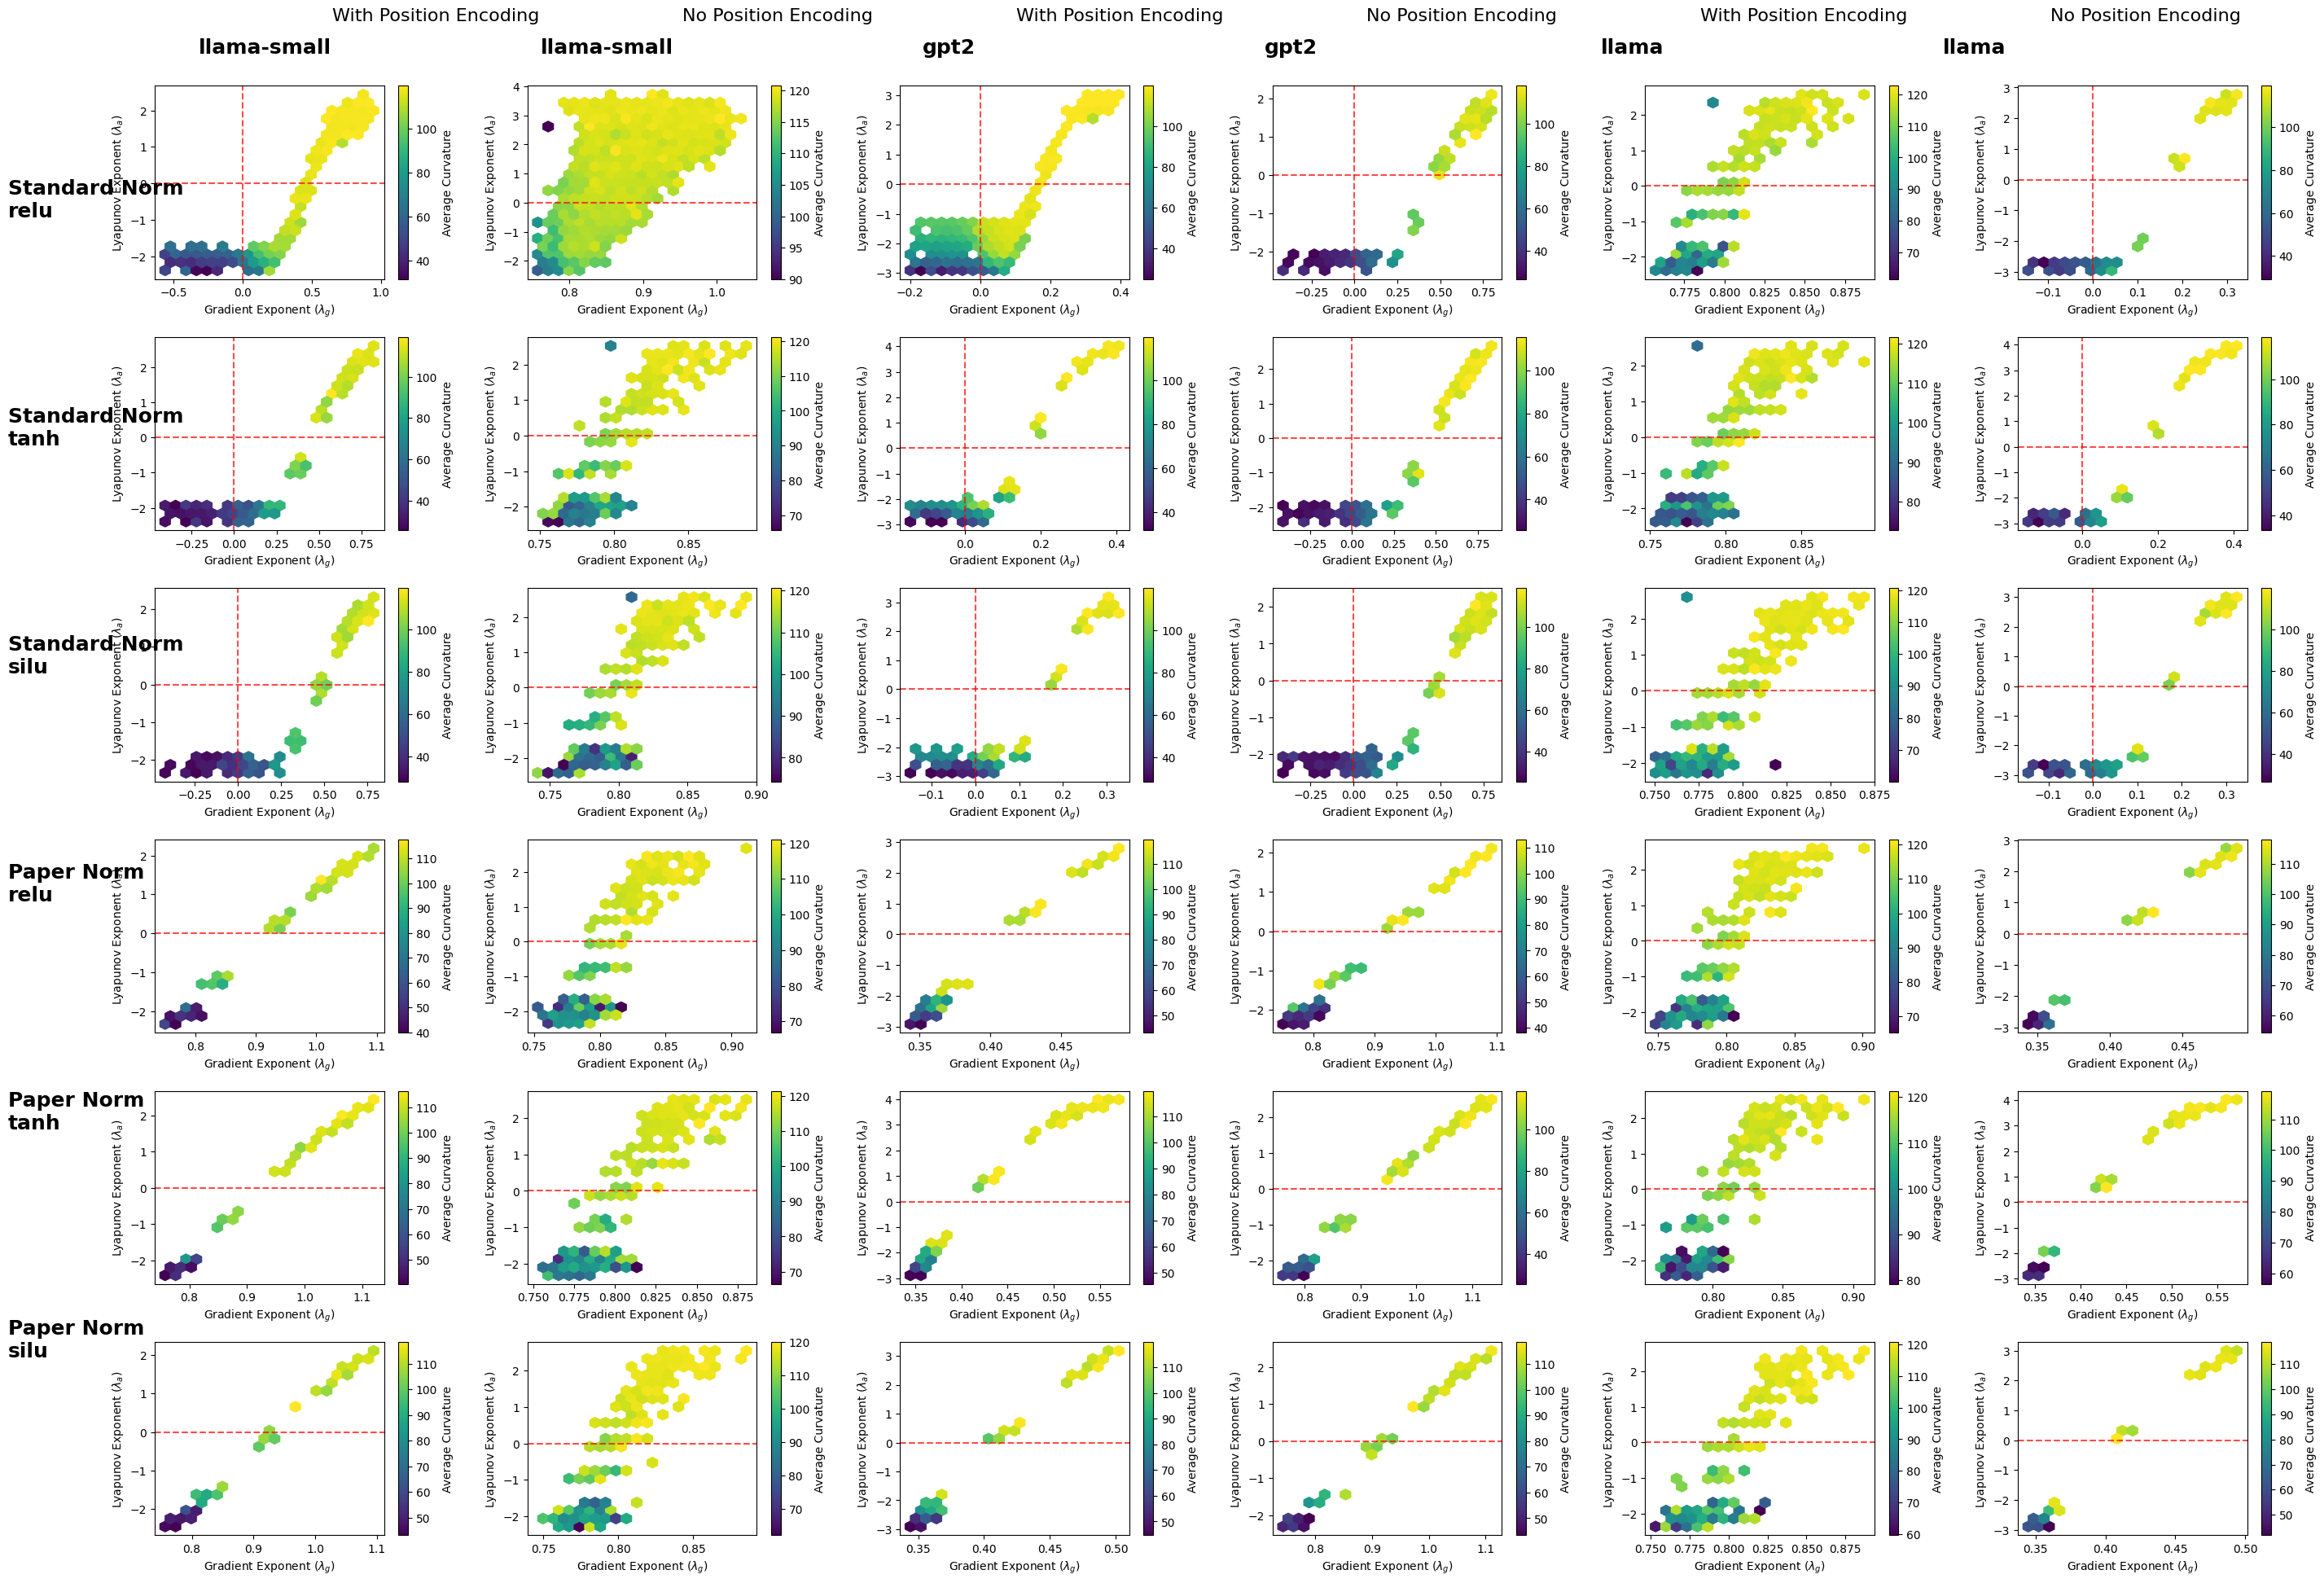

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 6x6 grid for 36 subplots with larger figure size
fig, axes = plt.subplots(6, 6, figsize=(30, 20))

# Define row and column labels
model_names = ["llama-small", "gpt2", "llama"]
activation_functions = ["relu", "tanh", "silu"]
norm_labels = ["Standard Norm", "Paper Norm"]
pos_enc_labels = ["With Position Encoding", "No Position Encoding"]

# Add column titles (model names) - adjusted for larger figure
for i, model in enumerate(model_names):
    for j in range(2):  # Two columns per model (position encoding True/False)
        col_idx = i*2 + j
        fig.text(0.125 + col_idx*0.14, 0.96, model, ha='center', fontsize=18, fontweight='bold')

# Add row titles - adjusted for larger figure
for i, norm in enumerate(norm_labels):
    for j, act in enumerate(activation_functions):
        row_idx = i*3 + j
        fig.text(0.02, 0.87 - row_idx*0.14, f"{norm}\n{act}", va='center', fontsize=18, fontweight='bold')

# Add position encoding labels - adjusted for larger figure
fig.text(0.195, 0.98, pos_enc_labels[0], ha='center', fontsize=16)
fig.text(0.335, 0.98, pos_enc_labels[1], ha='center', fontsize=16)
fig.text(0.475, 0.98, pos_enc_labels[0], ha='center', fontsize=16)
fig.text(0.615, 0.98, pos_enc_labels[1], ha='center', fontsize=16)
fig.text(0.755, 0.98, pos_enc_labels[0], ha='center', fontsize=16)
fig.text(0.895, 0.98, pos_enc_labels[1], ha='center', fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()
plot_idx = 0

for use_paper_norm in [False, True]:
    for activation_function in ["relu", "tanh", "silu"]:
        for use_position_encoding in [True, False]:
            for model_name in ["llama-small", "gpt2", "llama"]:
                # Load the data
                lyapunov_exponents = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_lyapunov_exponents.npy")
                gradient_exponents = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_gradient_exponents.npy")
                curves = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_curves.npy")
                
                try:
                    curves = np.mean(curves, axis=-1)[:, :, 10]
                except Exception:
                    curves = curves[:, :, 10]
                
                # Get the current axis from the grid
                ax = axes[plot_idx]
                
                # Plot on the given axis without individual titles
                create_binned_heatmap(
                    gradient_exponents.flatten(),
                    lyapunov_exponents.flatten(),
                    curves=curves.flatten(),
                    nbins=20,
                    model_name=None,
                    activation_function=None,
                    use_paper_norm=None,
                    use_position_encoding=None,
                    ax=ax
                )
                
                plot_idx += 1

plt.subplots_adjust(top=0.94, bottom=0.05, left=0.08, right=0.96, hspace=0.3, wspace=0.3)
plt.show()


In [35]:
def plot_curves(curves, lyapunov_exponents, gradient_exponents):
    # (#num mlp sigmas, #num attention sigmas, #num layers, #num tokens)
    plt.figure(figsize=(15, 8))
    j = 10
    for i in range(1, curves.shape[0], curves.shape[0]//8):
        plt.plot(np.mean(curves[i, j, :, :], axis=-1), label="mlp sigma: " + str(np.round(sigmas[i, j, 1], 2)) + " angle exp: " + str(np.round(lyapunov_exponents[i, j], 2)) + " grad exp: " + str(np.round(gradient_exponents[i, j], 2)))
    plt.legend()
    plt.xlabel("Layer")
    plt.ylabel("Average Curvature")
    plt.title("Average Curvature vs Layer for " + model_name + " with " + activation_function + " activation function, " + ("paper norm" if use_paper_norm else "no paper norm") + ", " + ("position encoding" if use_position_encoding else "no position encoding"))
    plt.show()

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  True
model_name:  llama-small


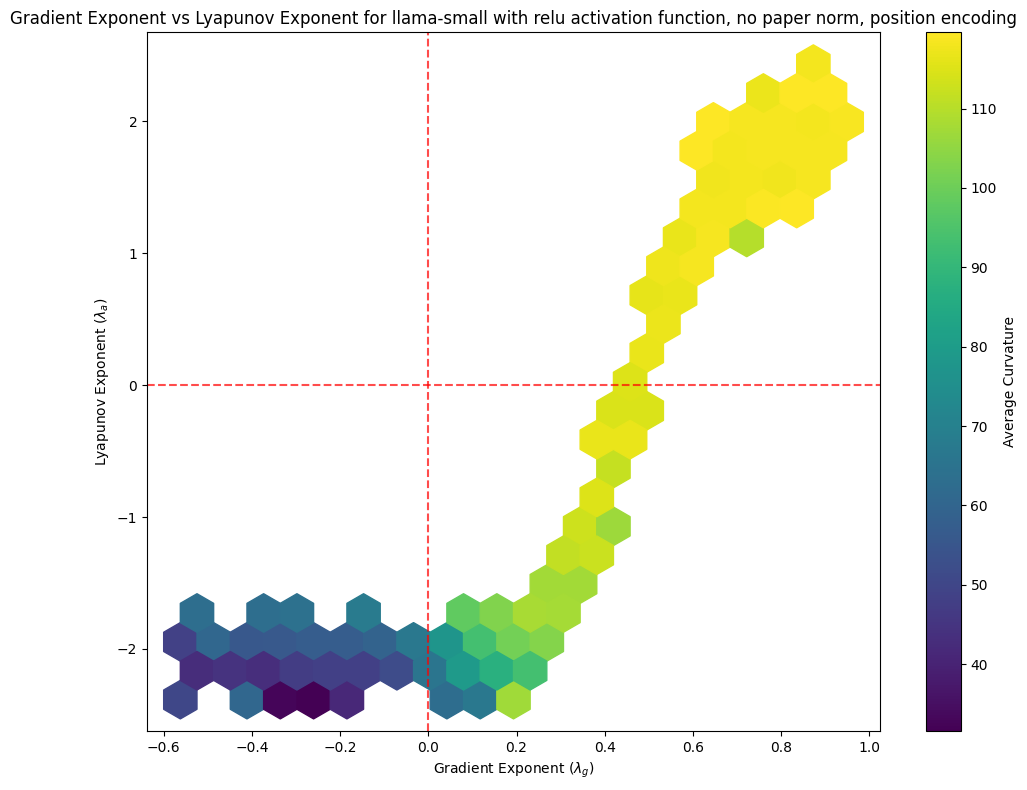

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  True
model_name:  gpt2


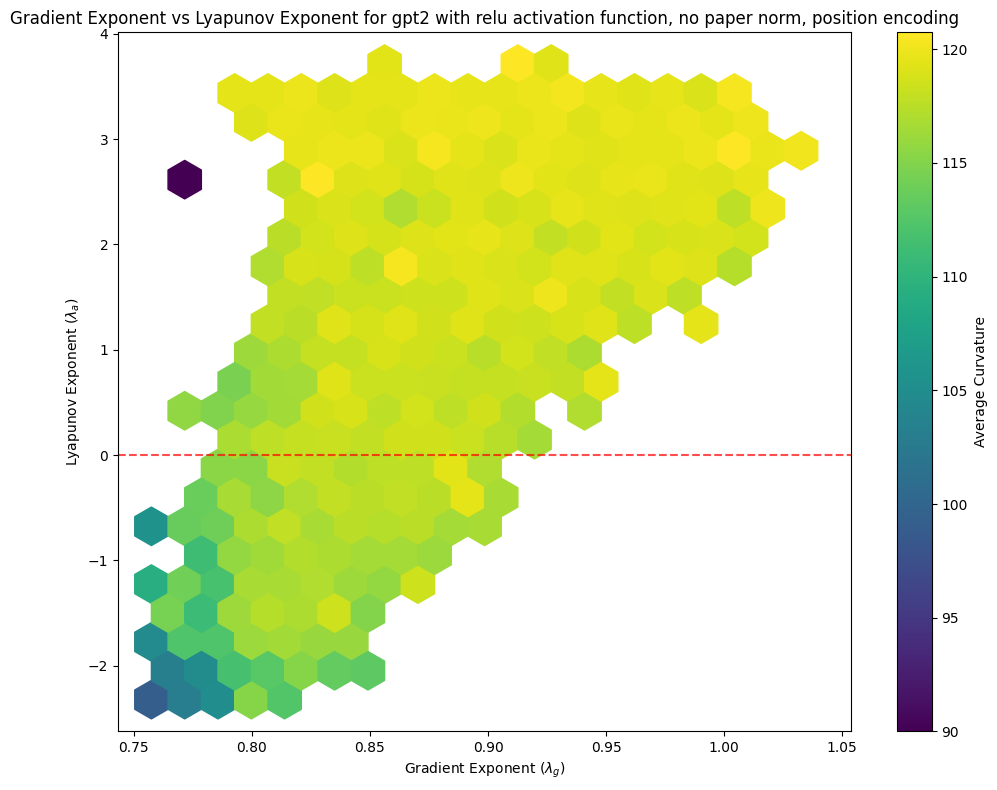

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  True
model_name:  llama


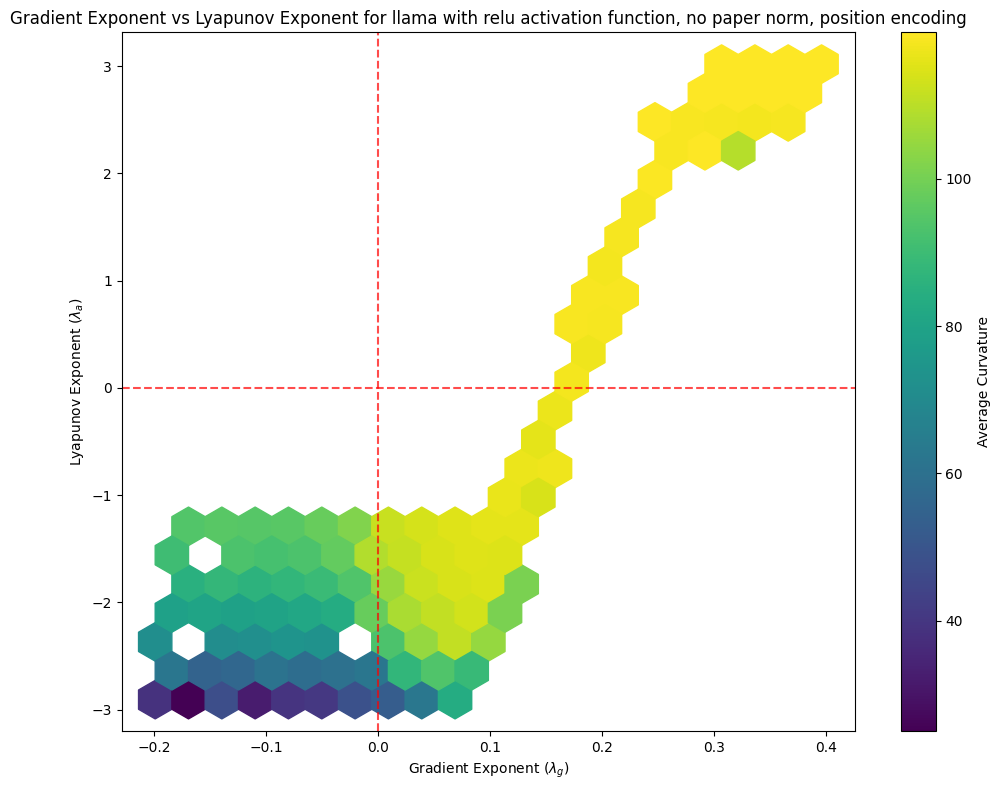

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  False
model_name:  llama-small


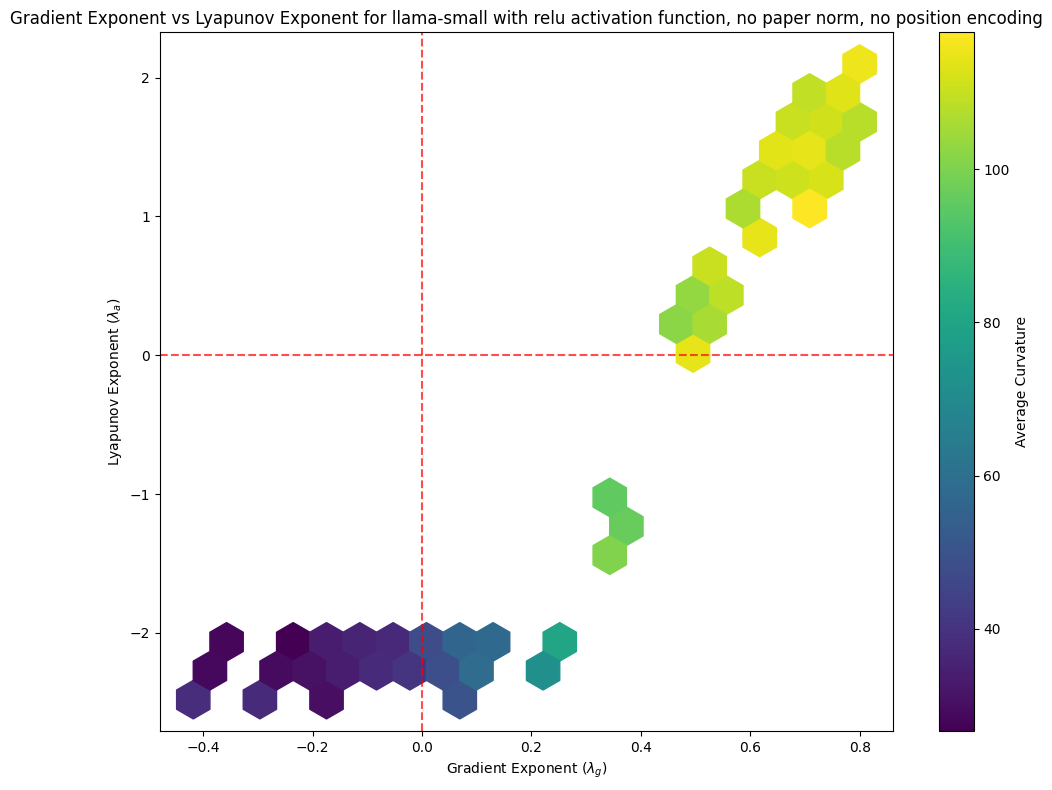

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  False
model_name:  gpt2


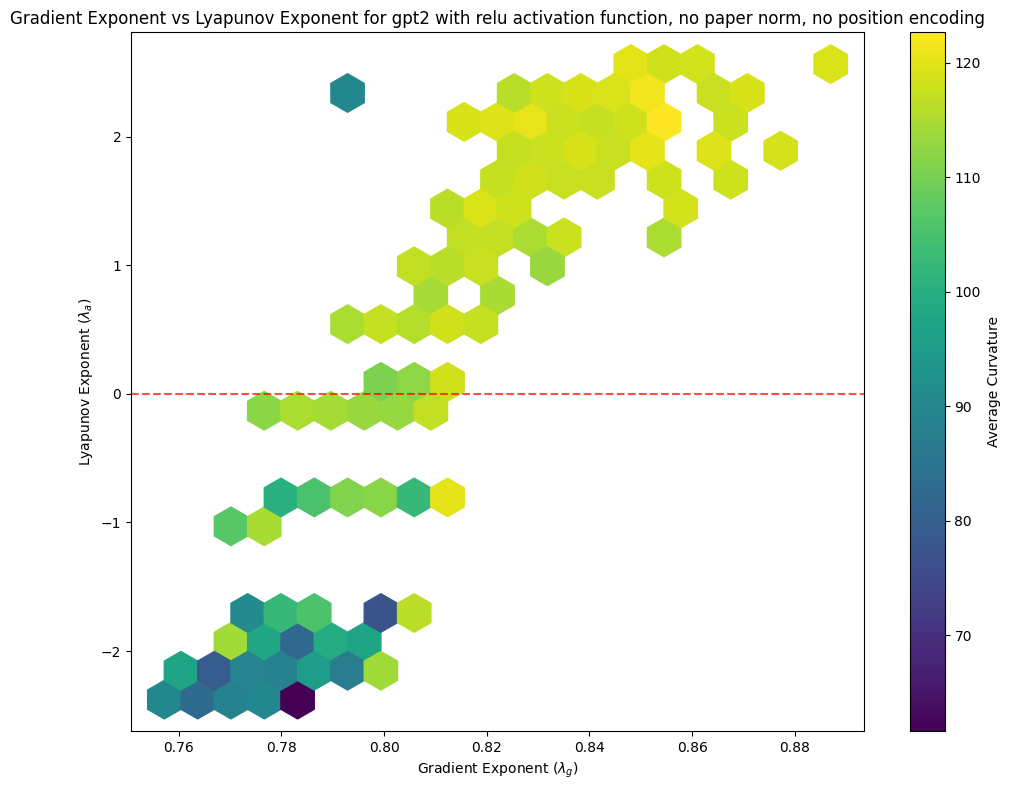

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  False
model_name:  llama


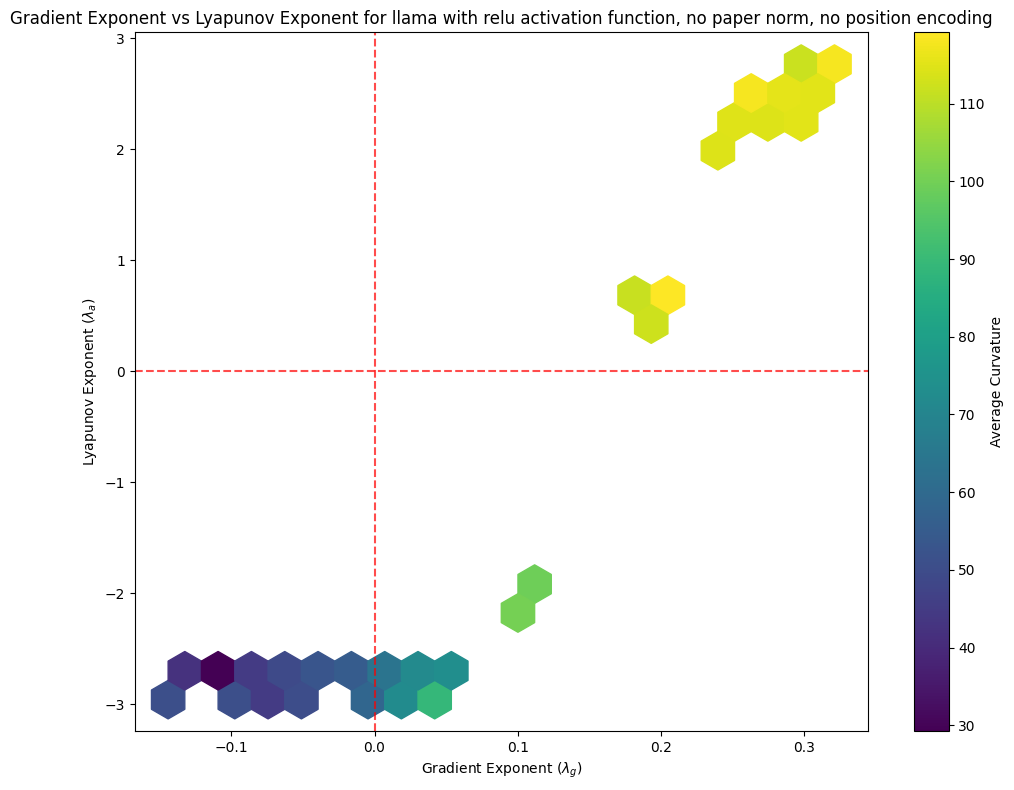

use_paper_norm:  False
activation_function:  tanh
use_position_encoding:  True
model_name:  llama-small


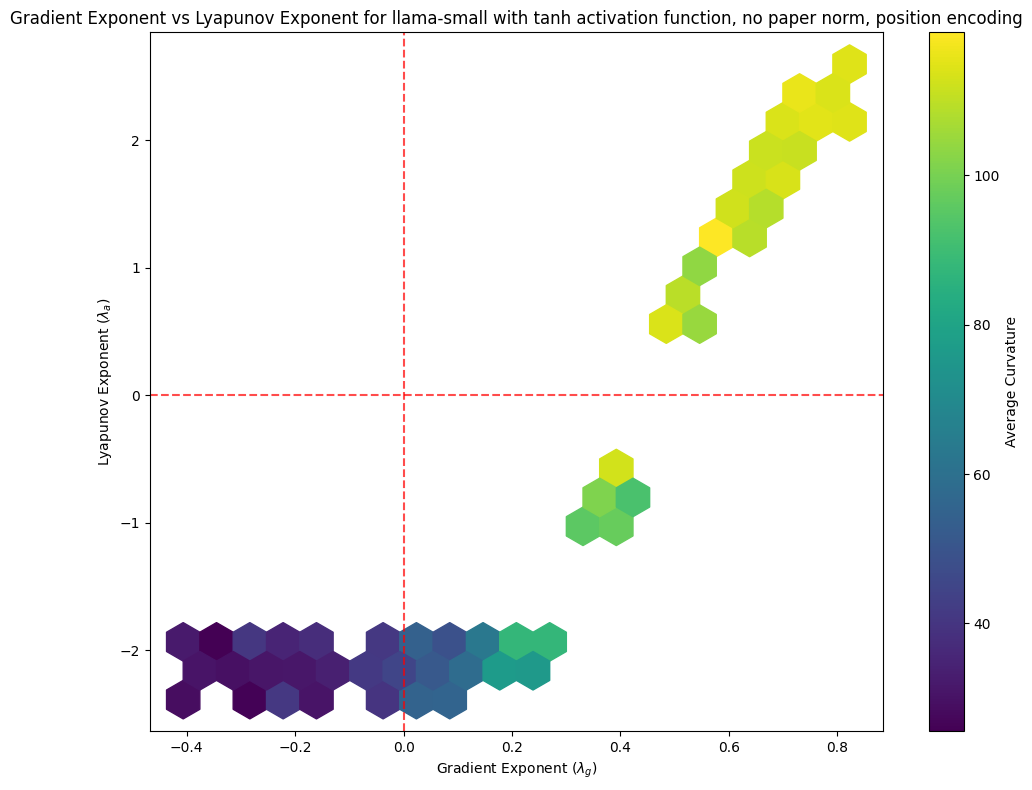

use_paper_norm:  False
activation_function:  tanh
use_position_encoding:  True
model_name:  gpt2


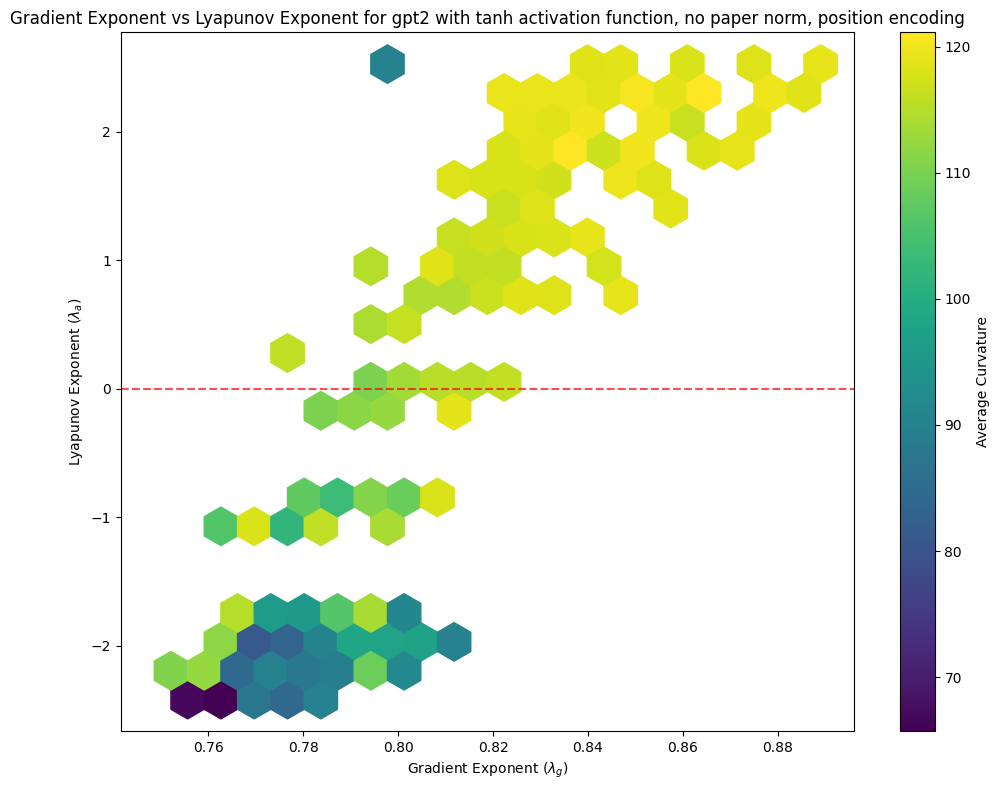

use_paper_norm:  False
activation_function:  tanh
use_position_encoding:  True
model_name:  llama


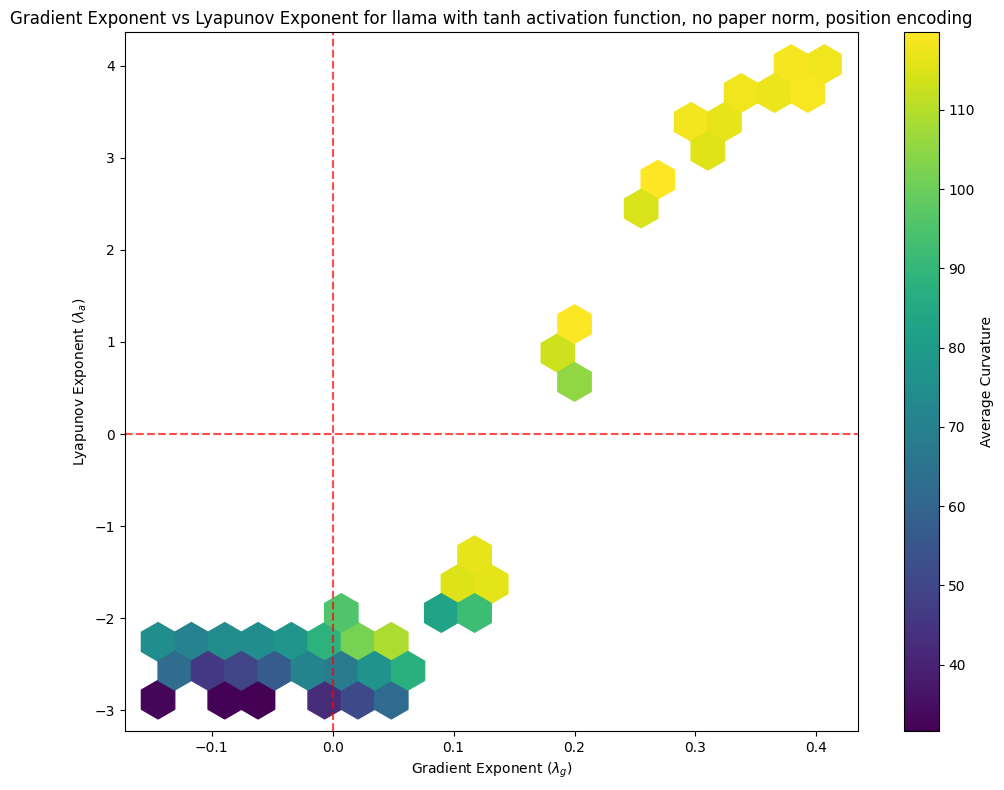

use_paper_norm:  False
activation_function:  tanh
use_position_encoding:  False
model_name:  llama-small


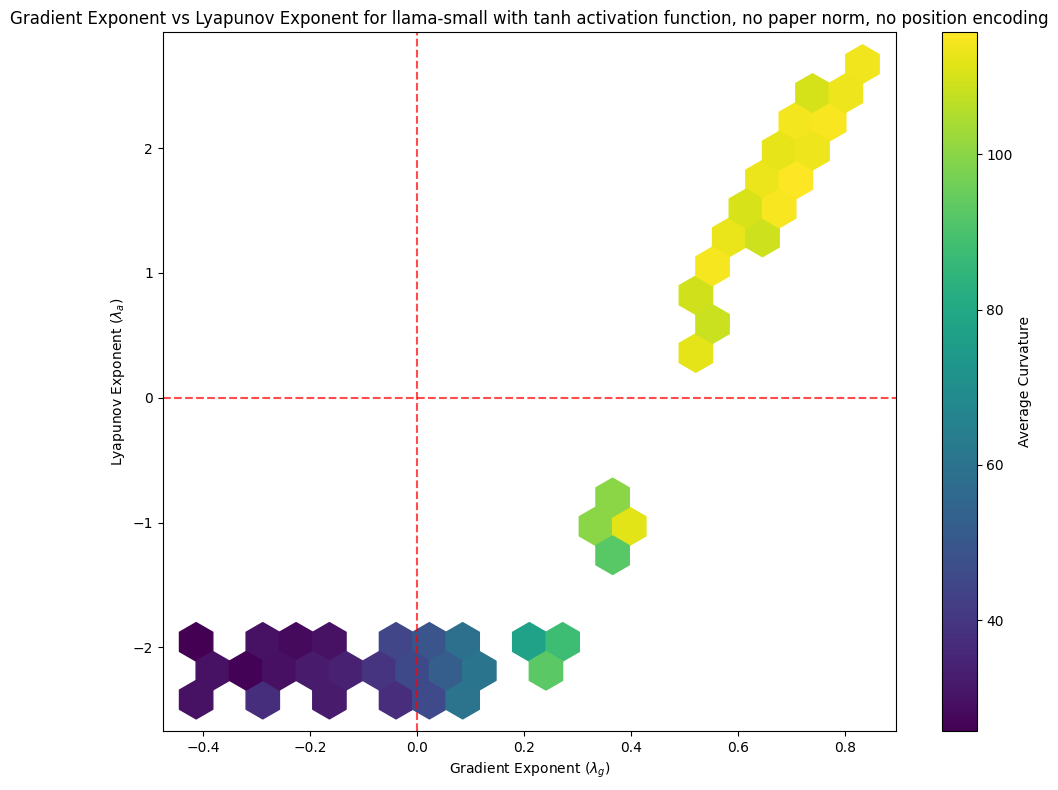

use_paper_norm:  False
activation_function:  tanh
use_position_encoding:  False
model_name:  gpt2


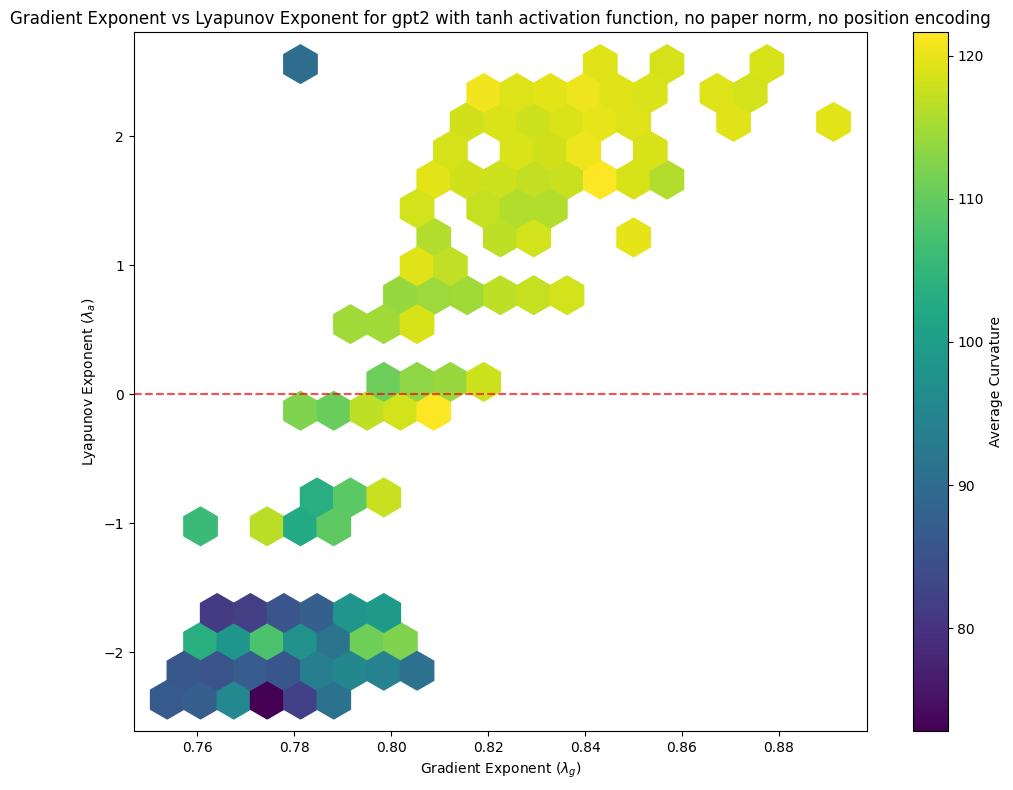

use_paper_norm:  False
activation_function:  tanh
use_position_encoding:  False
model_name:  llama


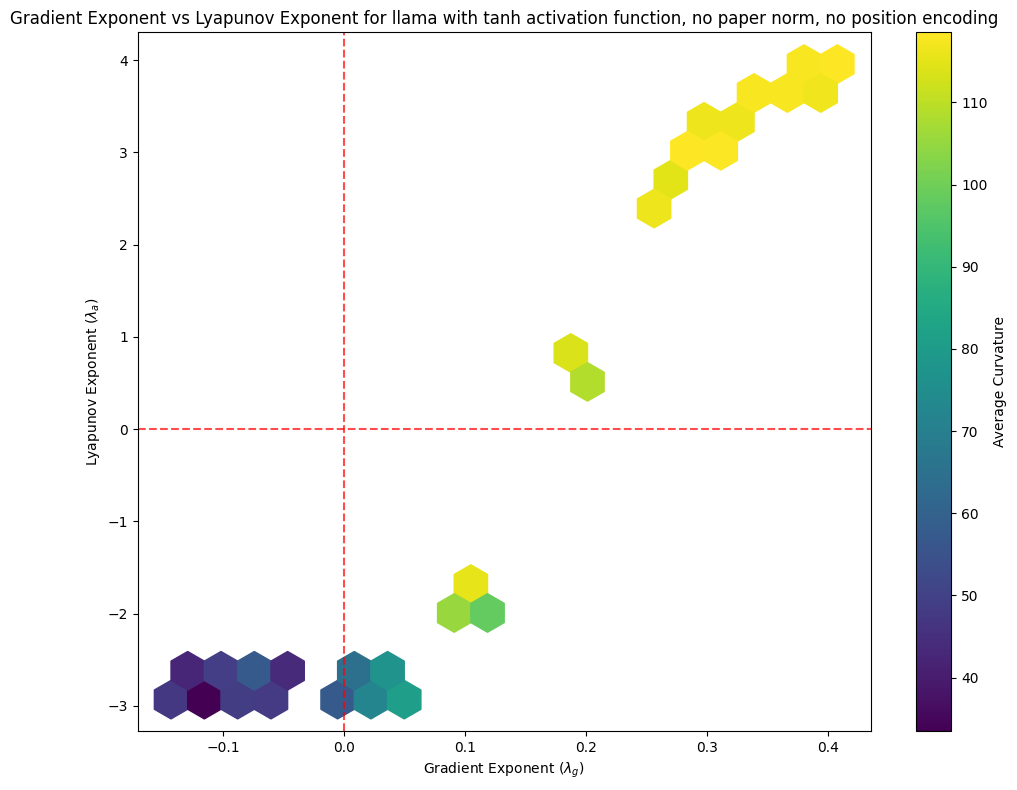

use_paper_norm:  False
activation_function:  silu
use_position_encoding:  True
model_name:  llama-small


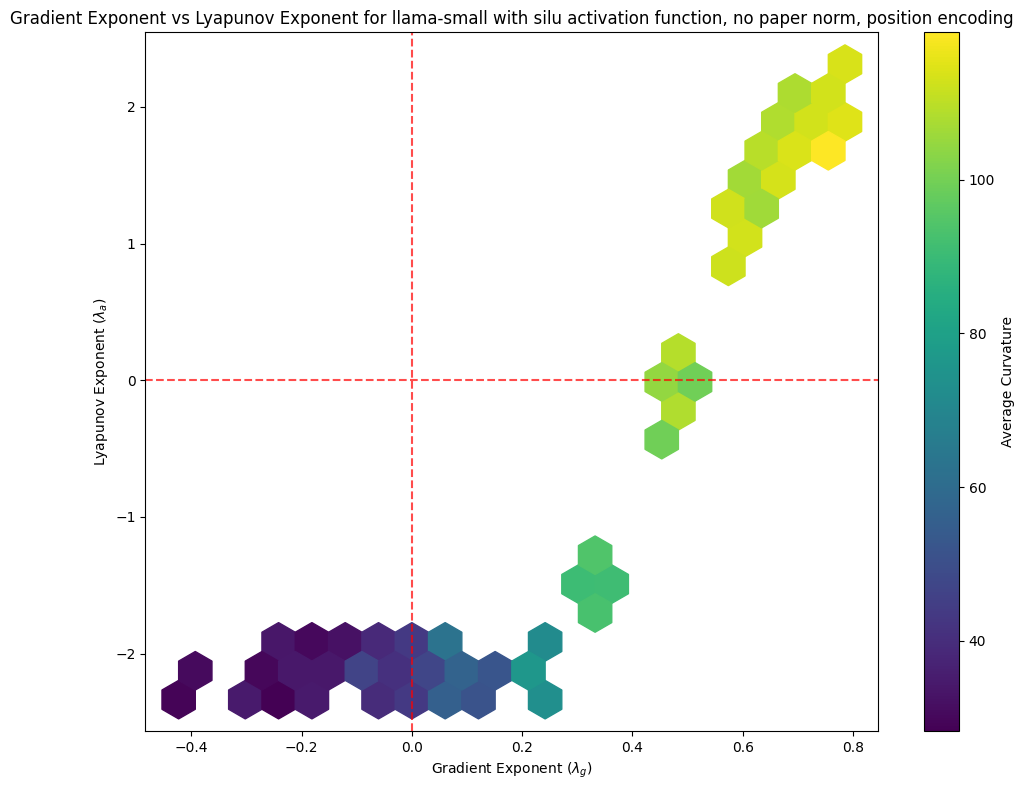

use_paper_norm:  False
activation_function:  silu
use_position_encoding:  True
model_name:  gpt2


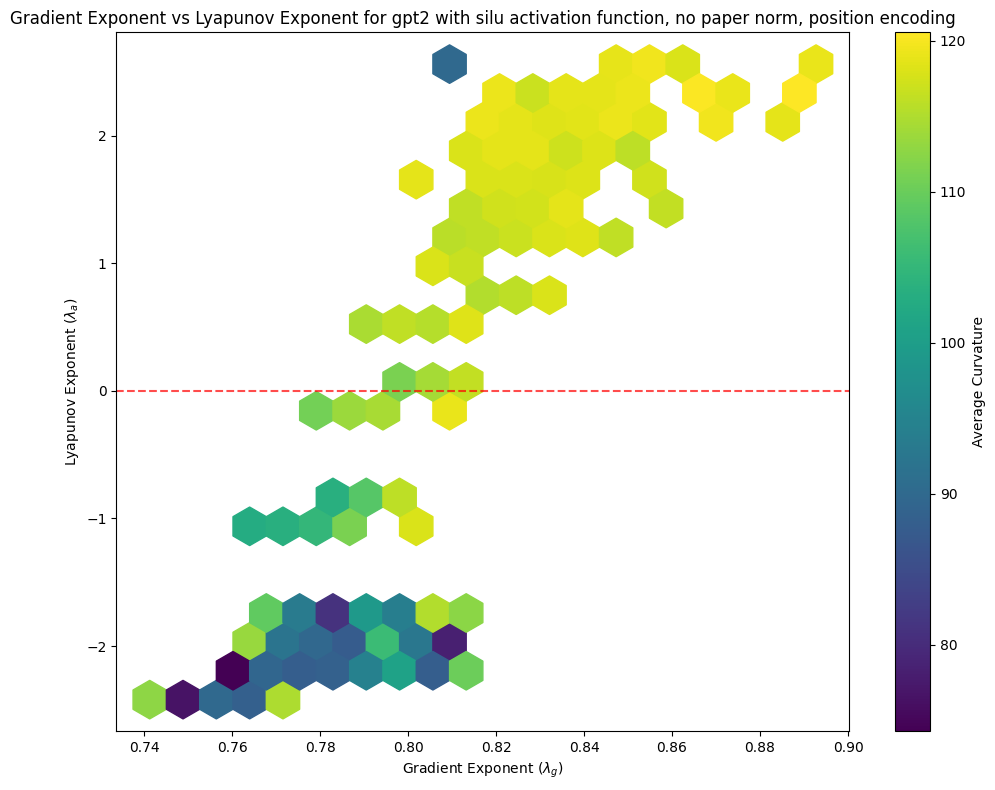

use_paper_norm:  False
activation_function:  silu
use_position_encoding:  True
model_name:  llama


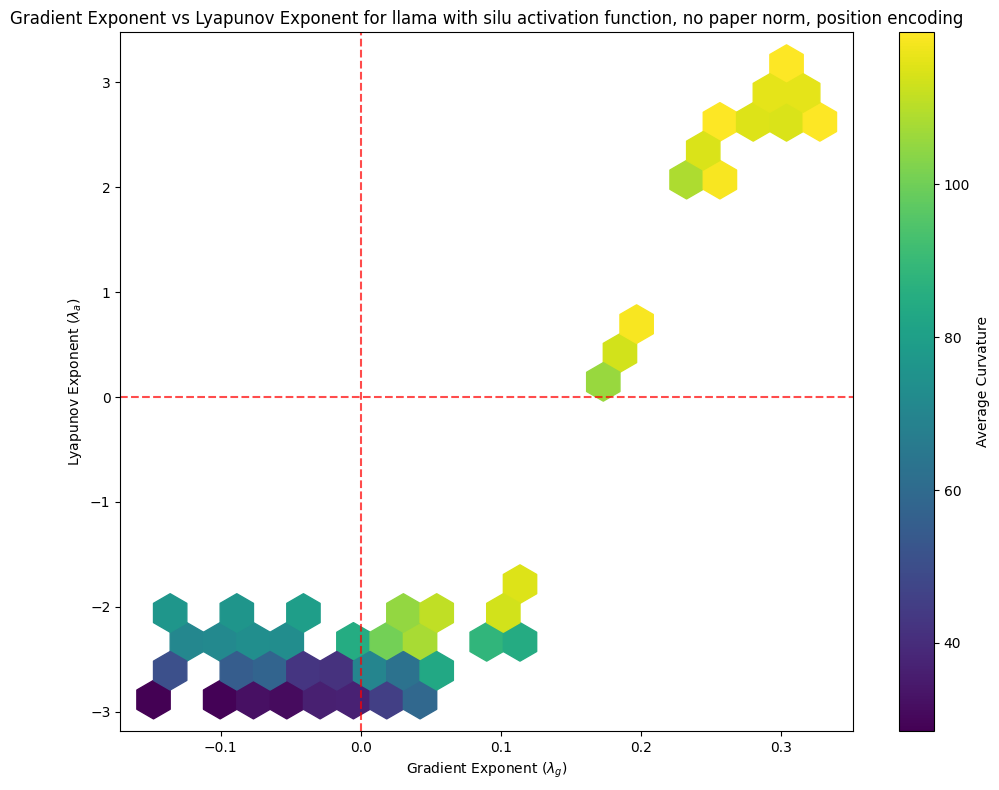

use_paper_norm:  False
activation_function:  silu
use_position_encoding:  False
model_name:  llama-small


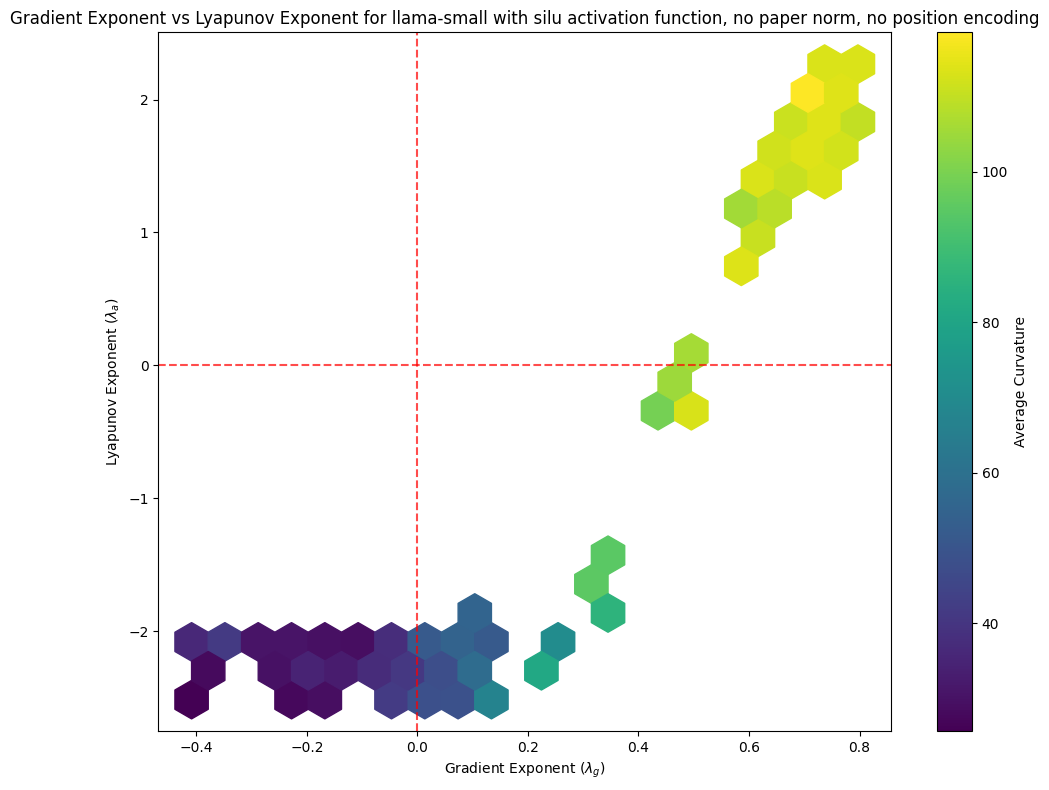

use_paper_norm:  False
activation_function:  silu
use_position_encoding:  False
model_name:  gpt2


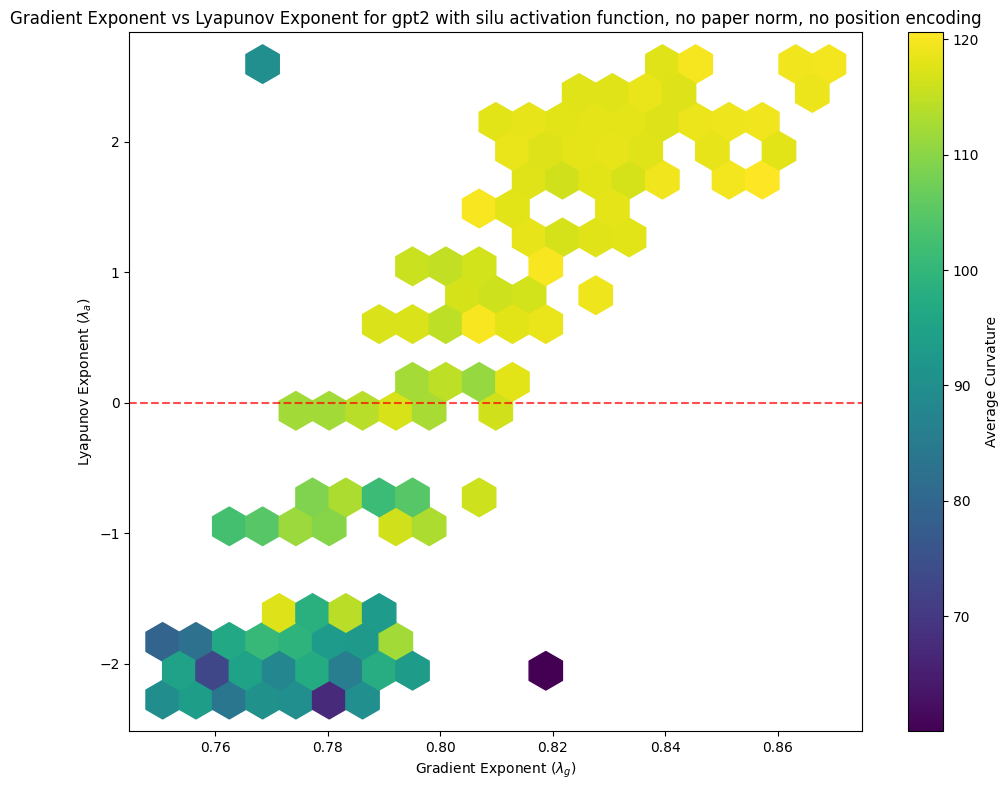

use_paper_norm:  False
activation_function:  silu
use_position_encoding:  False
model_name:  llama


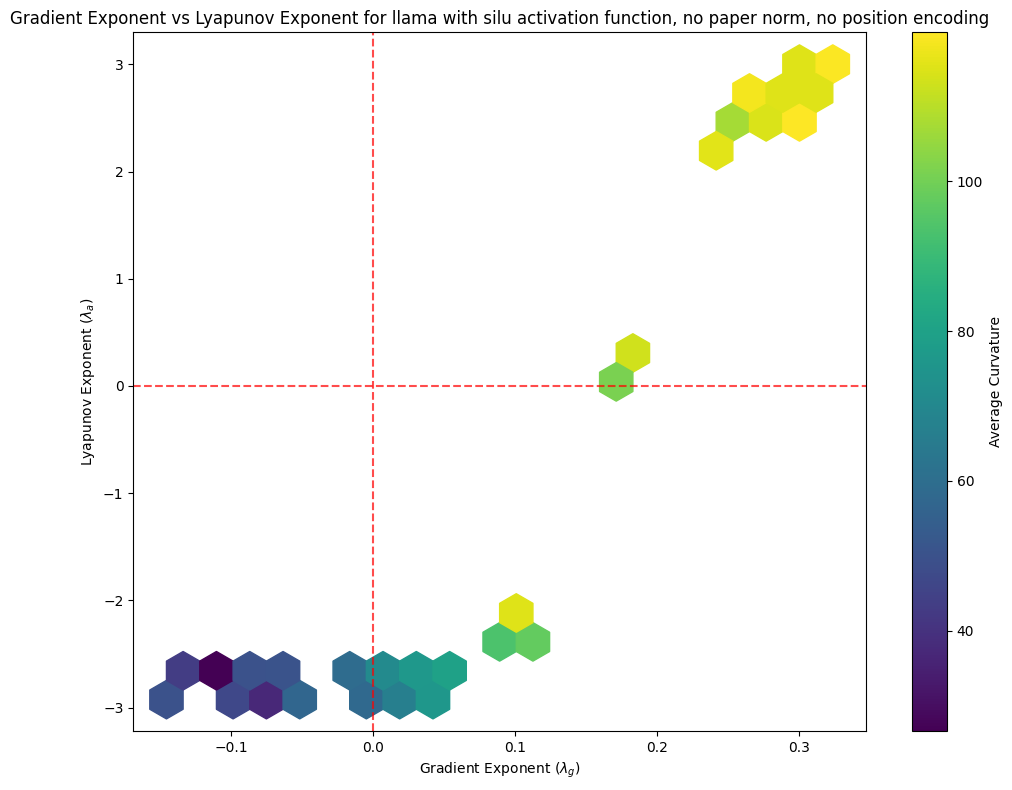

use_paper_norm:  True
activation_function:  relu
use_position_encoding:  True
model_name:  llama-small


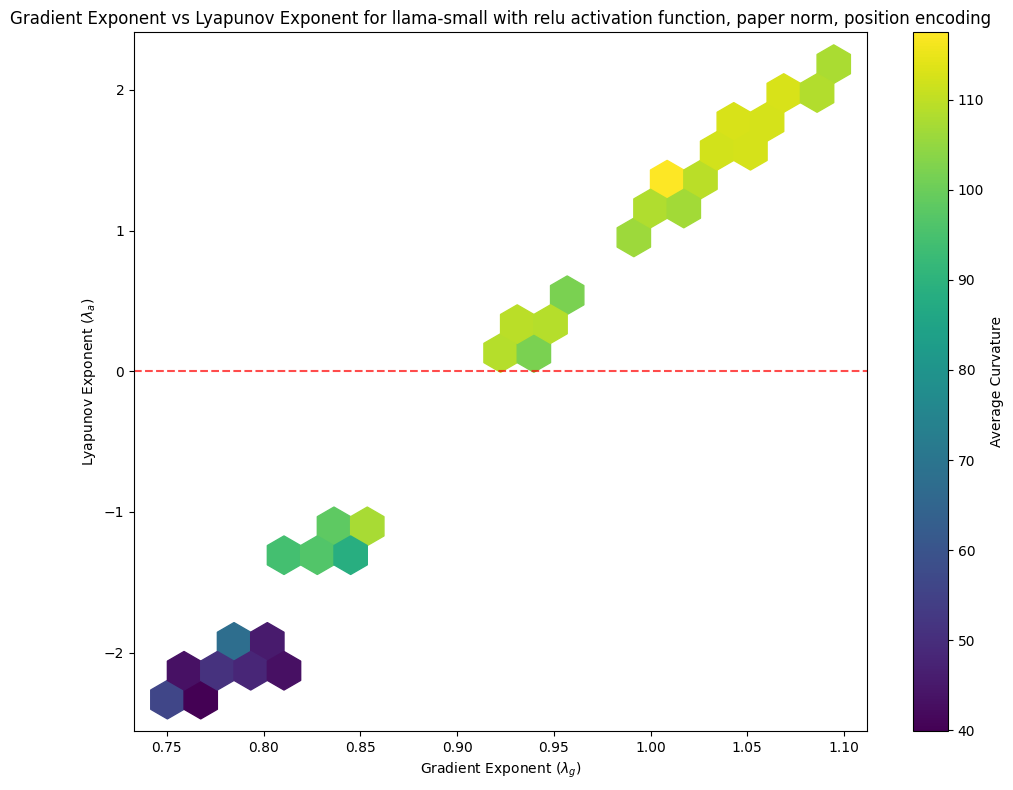

use_paper_norm:  True
activation_function:  relu
use_position_encoding:  True
model_name:  gpt2


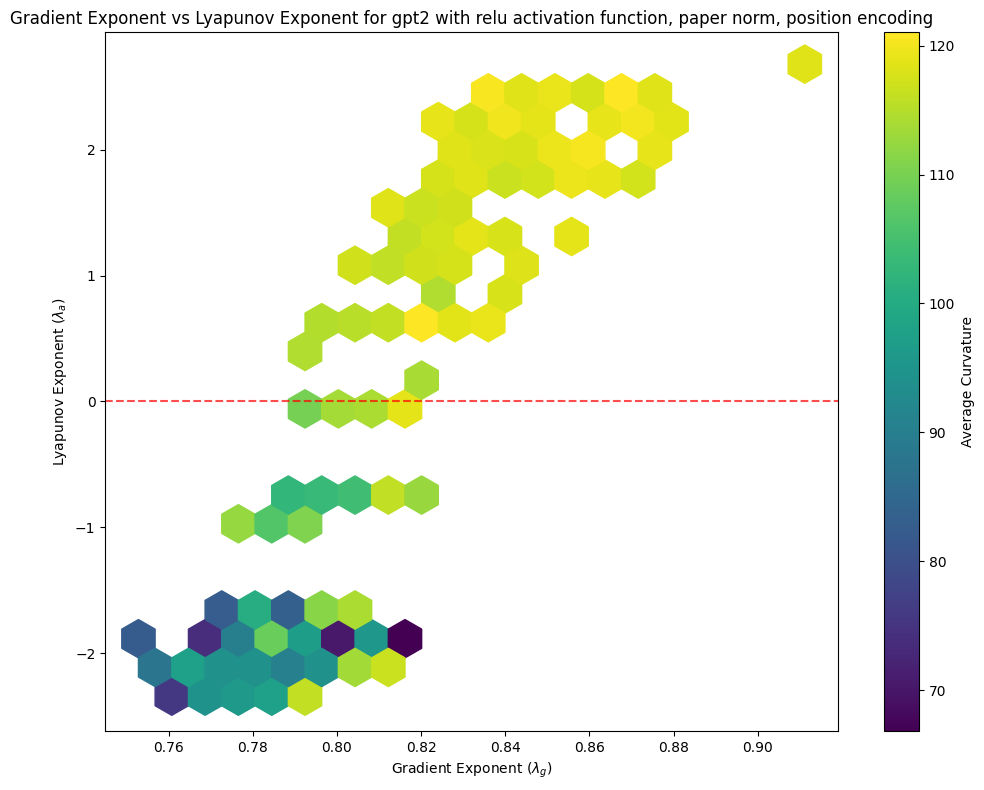

use_paper_norm:  True
activation_function:  relu
use_position_encoding:  True
model_name:  llama


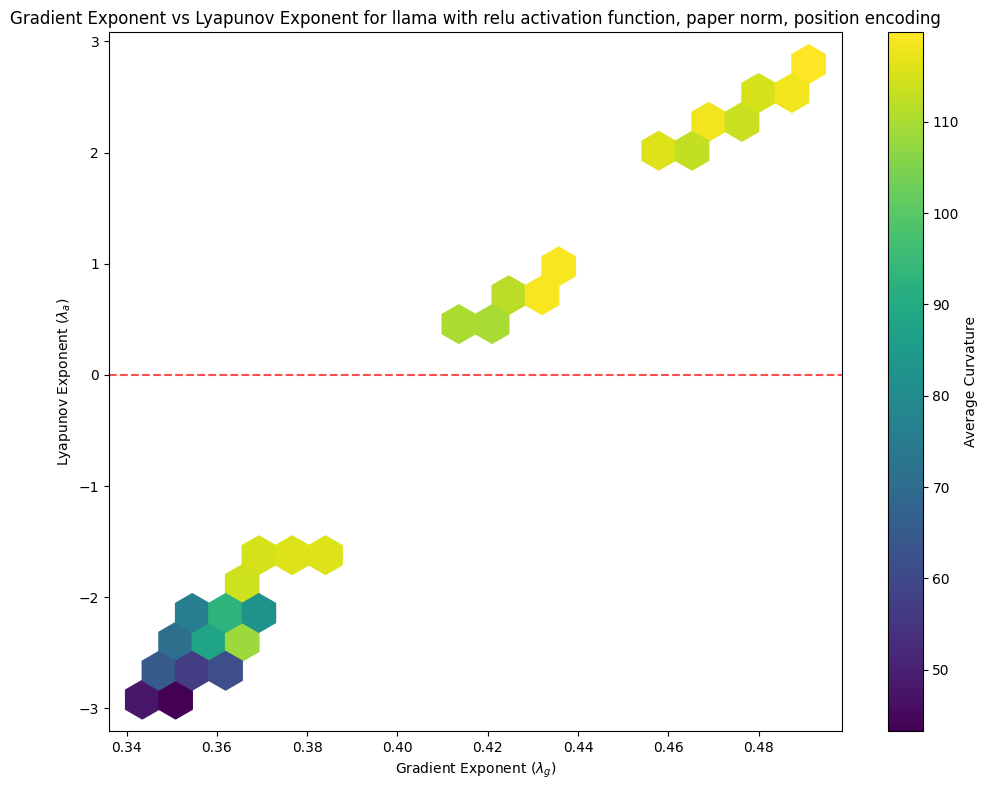

use_paper_norm:  True
activation_function:  relu
use_position_encoding:  False
model_name:  llama-small


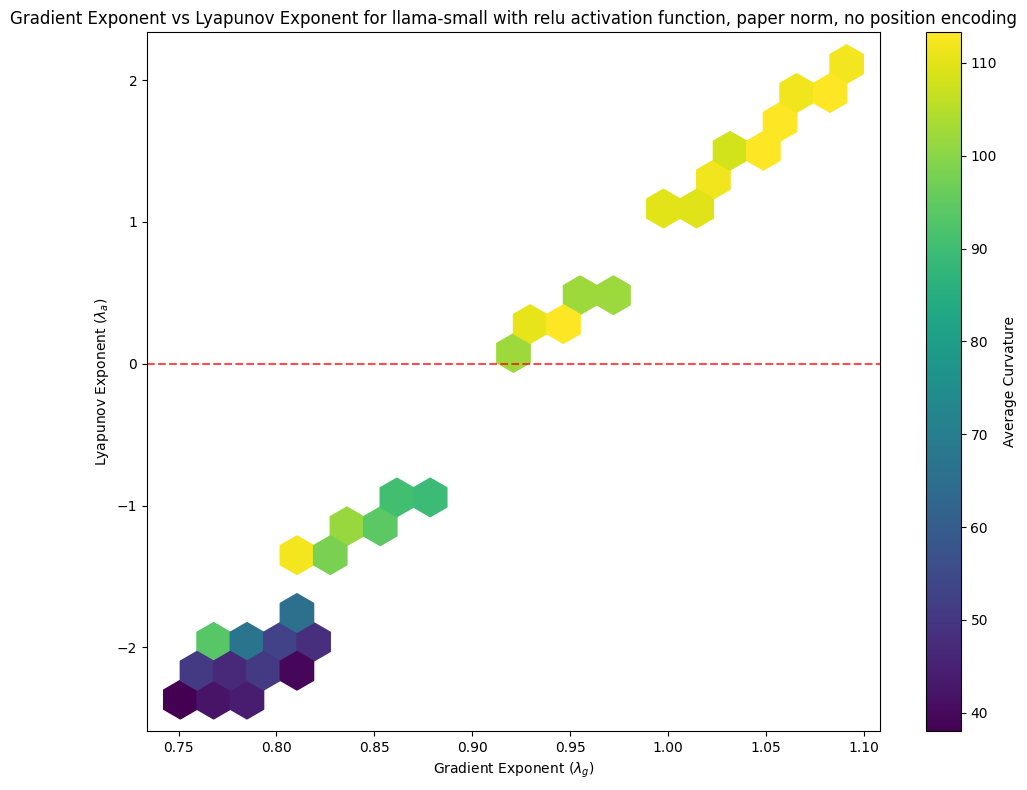

use_paper_norm:  True
activation_function:  relu
use_position_encoding:  False
model_name:  gpt2


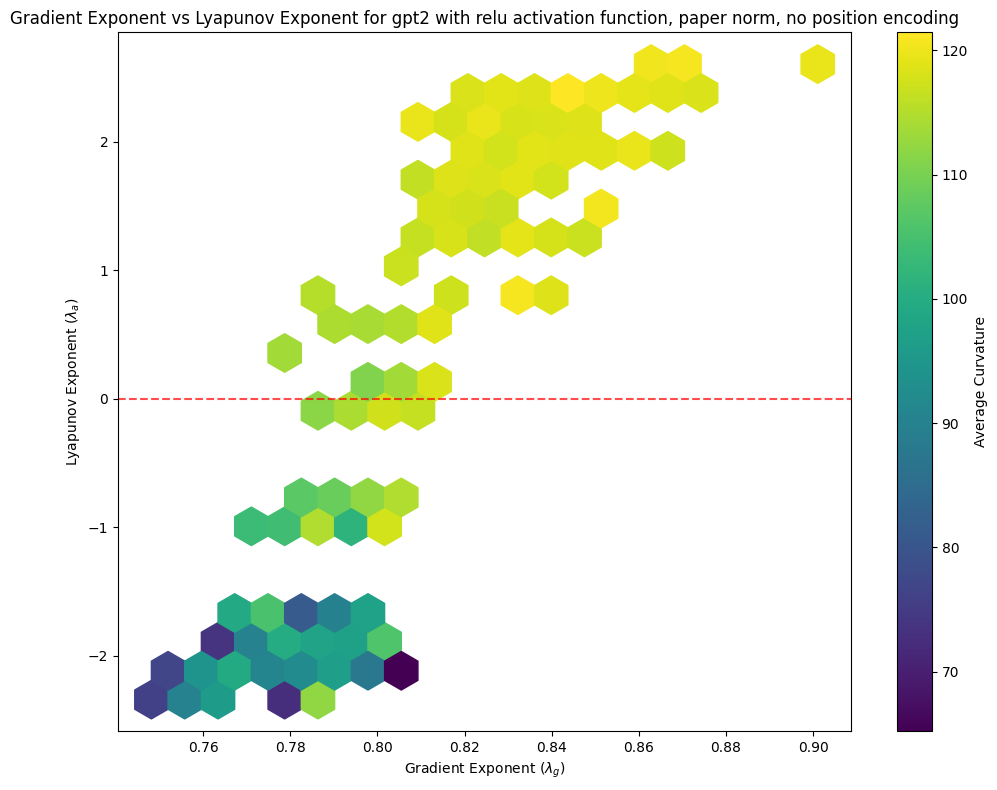

use_paper_norm:  True
activation_function:  relu
use_position_encoding:  False
model_name:  llama


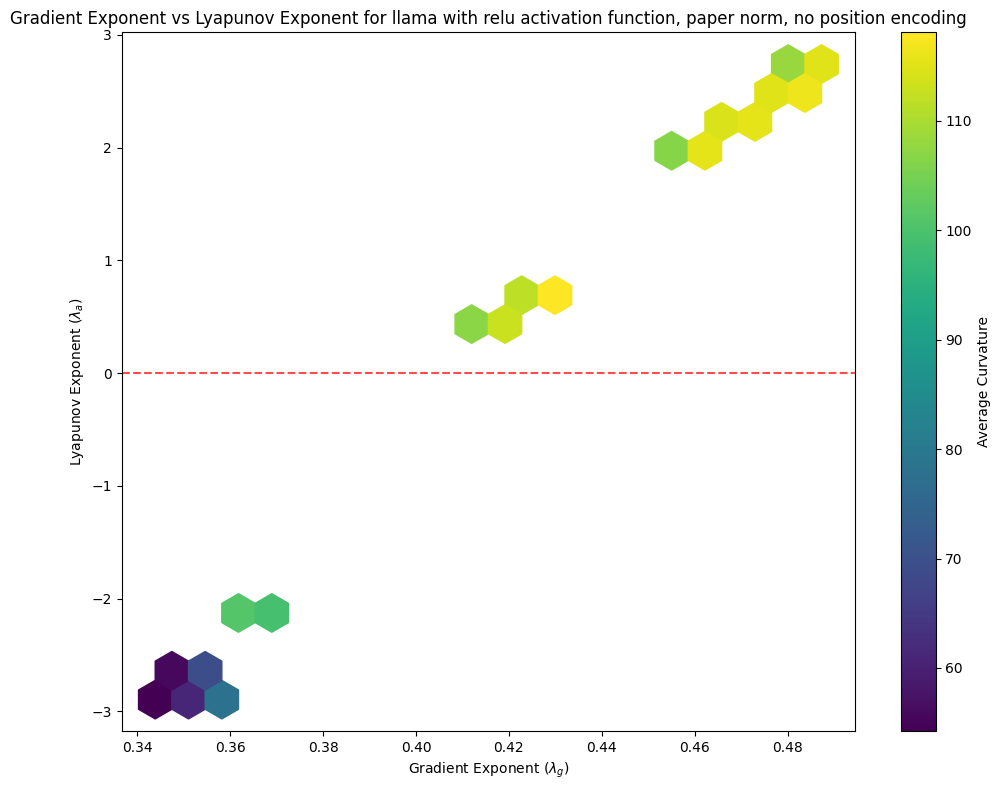

use_paper_norm:  True
activation_function:  tanh
use_position_encoding:  True
model_name:  llama-small


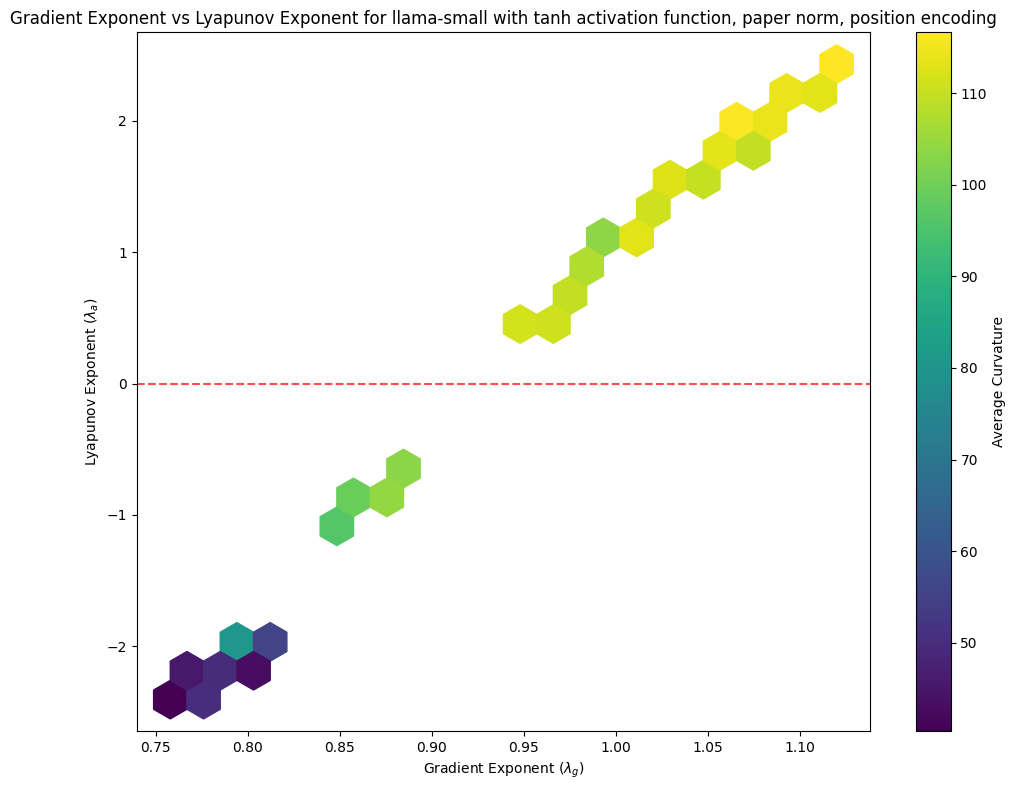

use_paper_norm:  True
activation_function:  tanh
use_position_encoding:  True
model_name:  gpt2


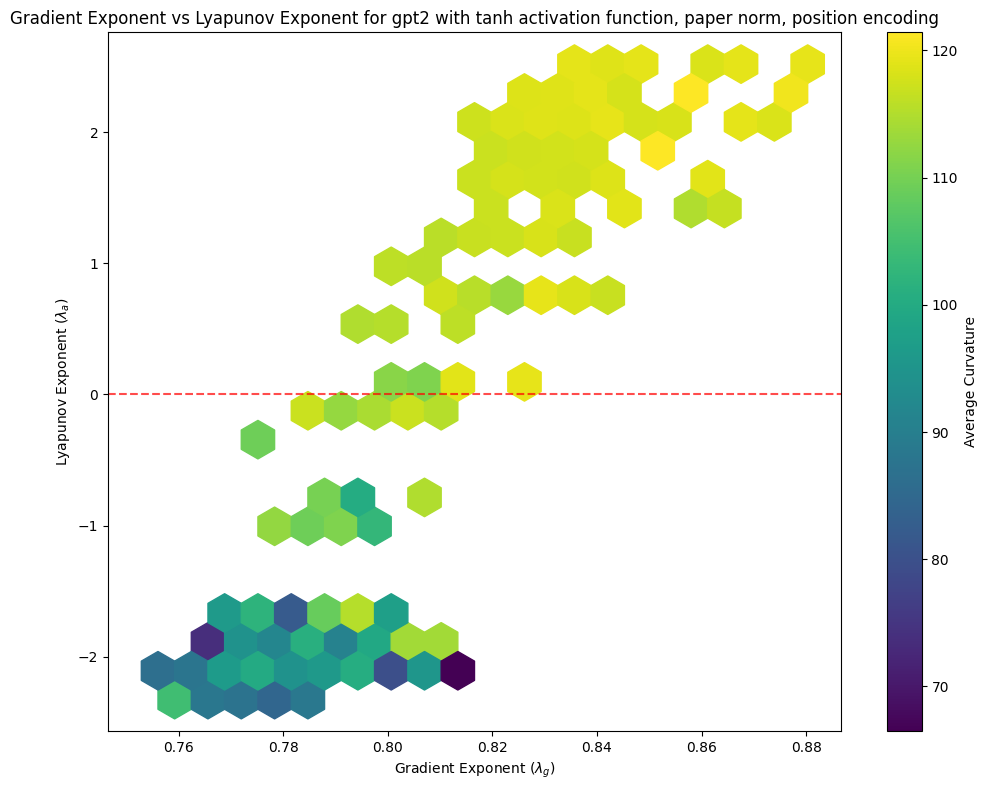

use_paper_norm:  True
activation_function:  tanh
use_position_encoding:  True
model_name:  llama


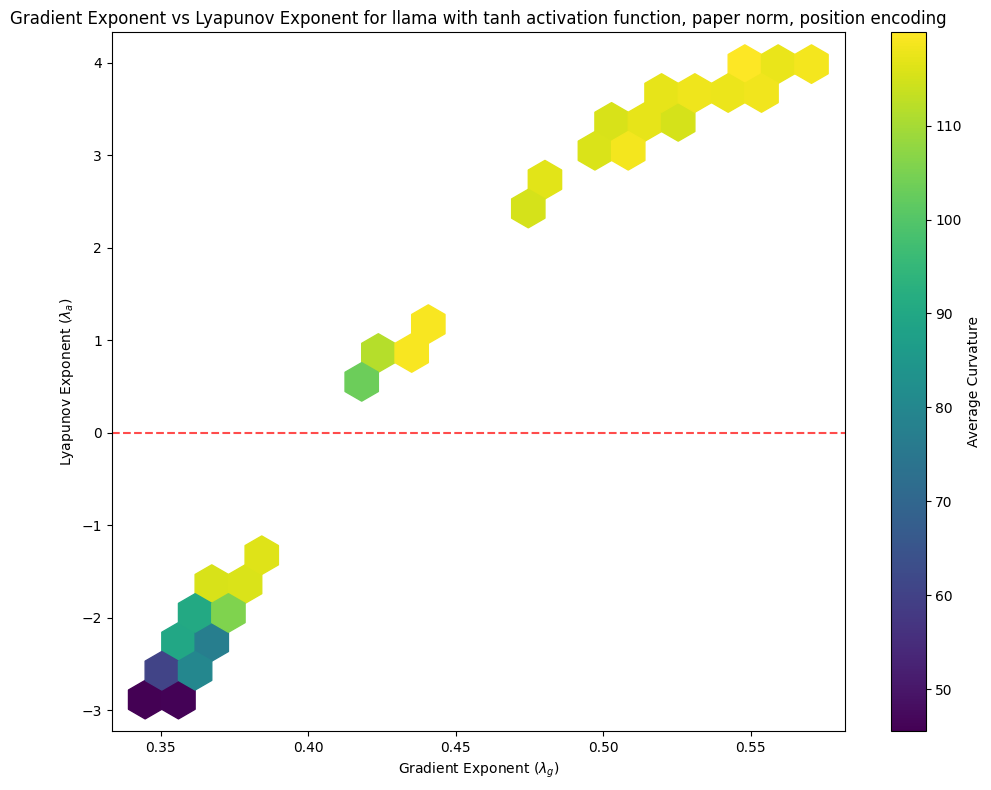

use_paper_norm:  True
activation_function:  tanh
use_position_encoding:  False
model_name:  llama-small


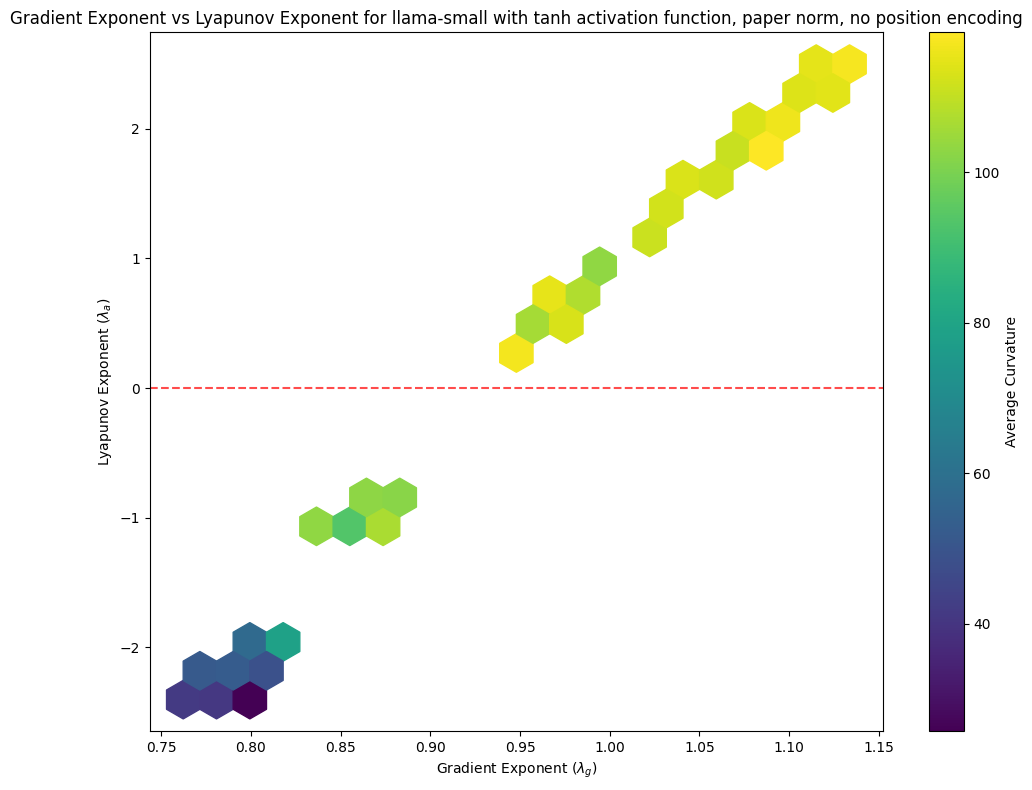

use_paper_norm:  True
activation_function:  tanh
use_position_encoding:  False
model_name:  gpt2


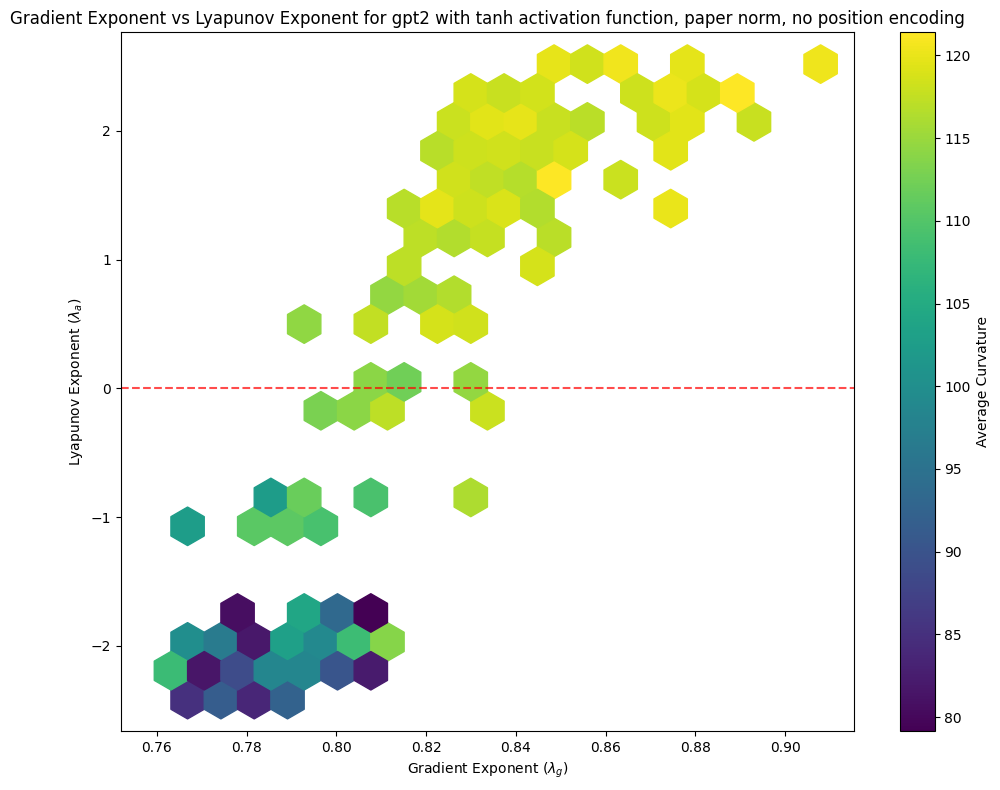

use_paper_norm:  True
activation_function:  tanh
use_position_encoding:  False
model_name:  llama


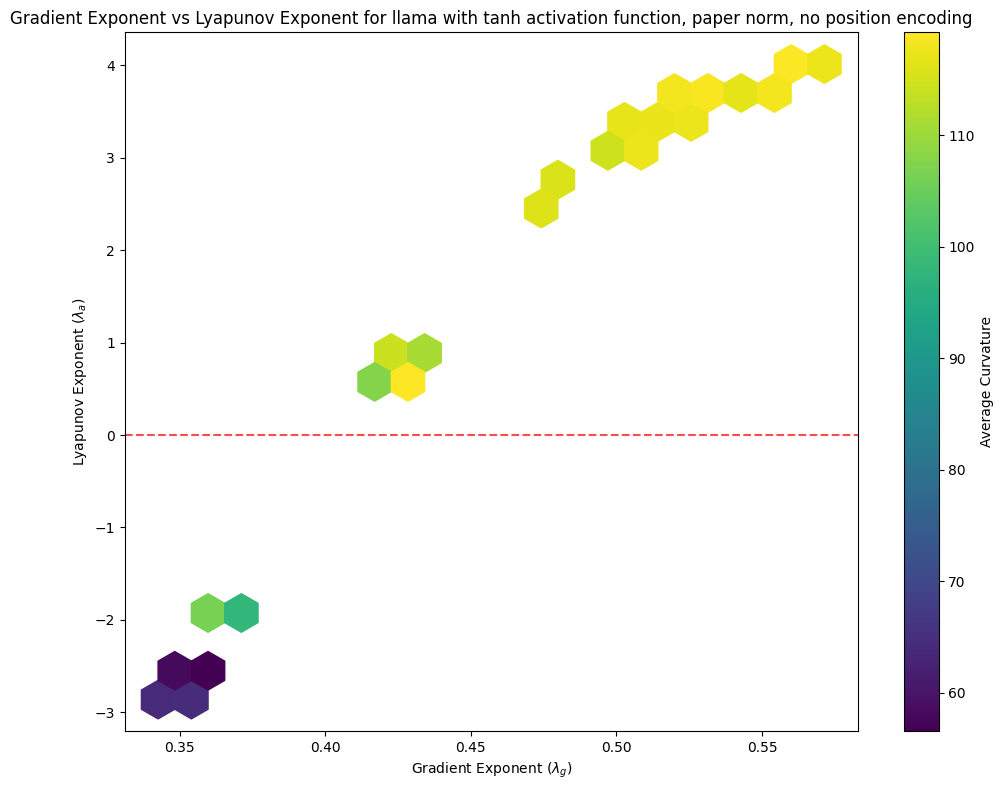

use_paper_norm:  True
activation_function:  silu
use_position_encoding:  True
model_name:  llama-small


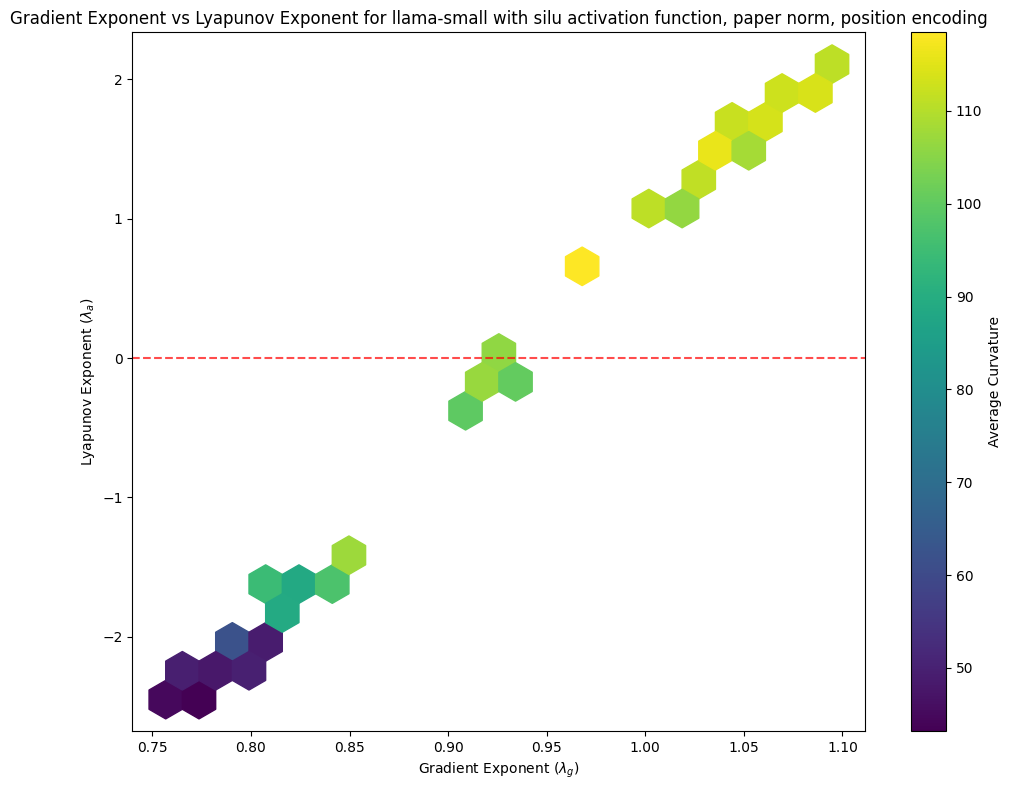

use_paper_norm:  True
activation_function:  silu
use_position_encoding:  True
model_name:  gpt2


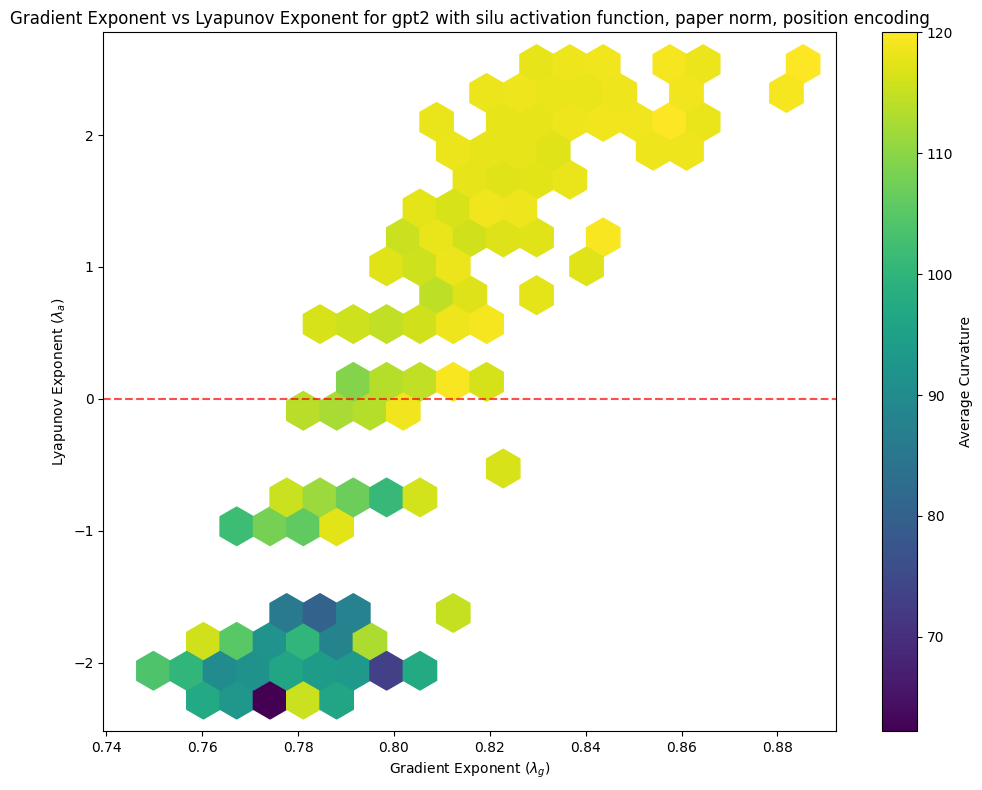

use_paper_norm:  True
activation_function:  silu
use_position_encoding:  True
model_name:  llama


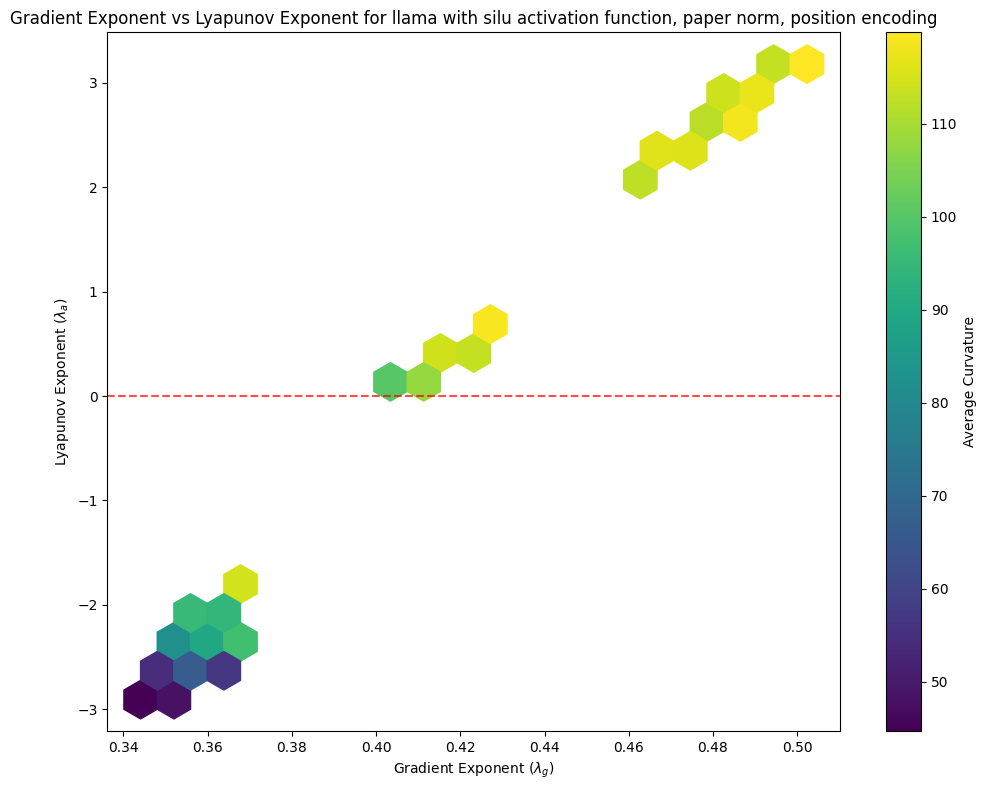

use_paper_norm:  True
activation_function:  silu
use_position_encoding:  False
model_name:  llama-small


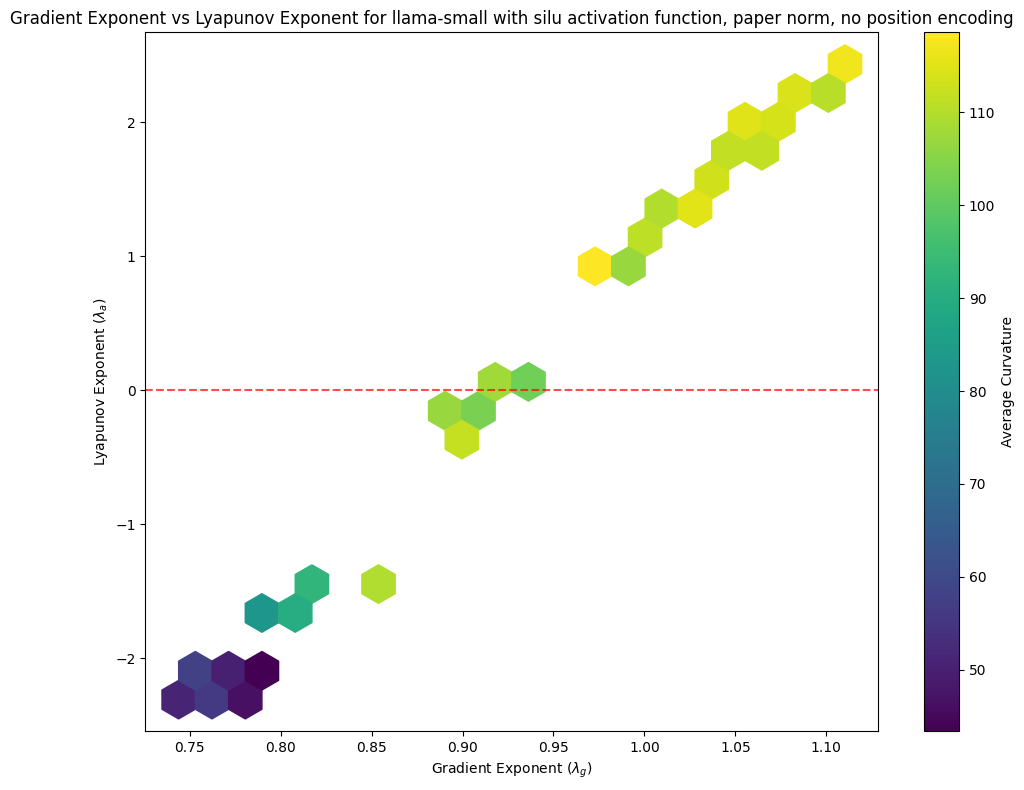

use_paper_norm:  True
activation_function:  silu
use_position_encoding:  False
model_name:  gpt2


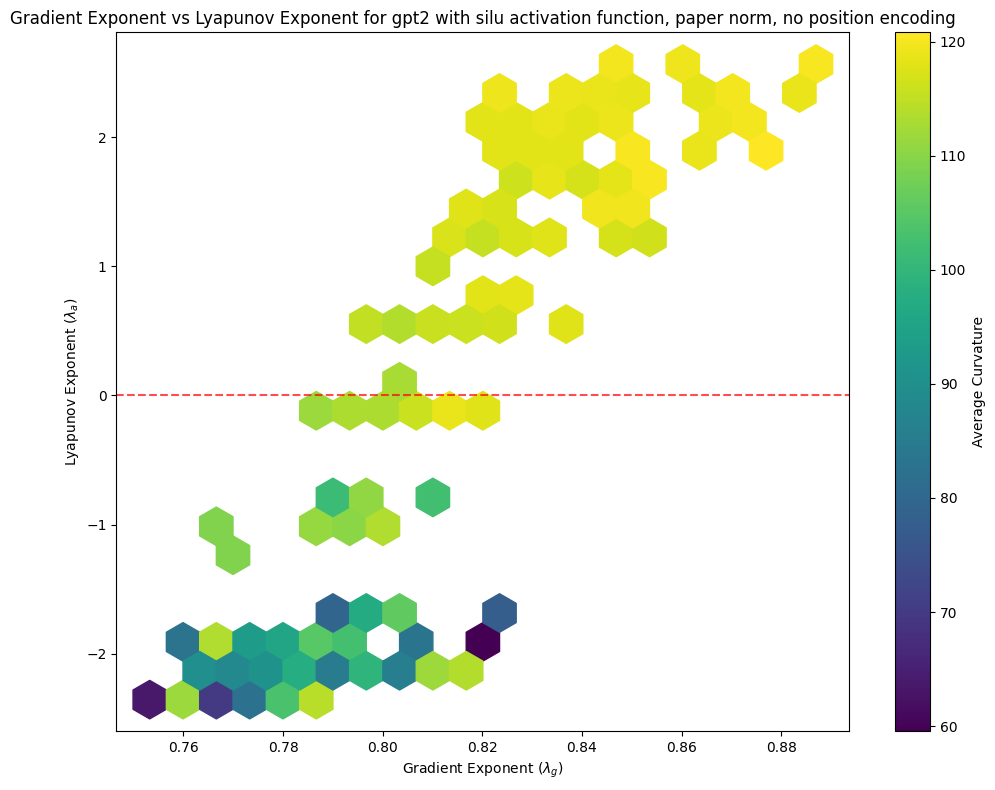

use_paper_norm:  True
activation_function:  silu
use_position_encoding:  False
model_name:  llama


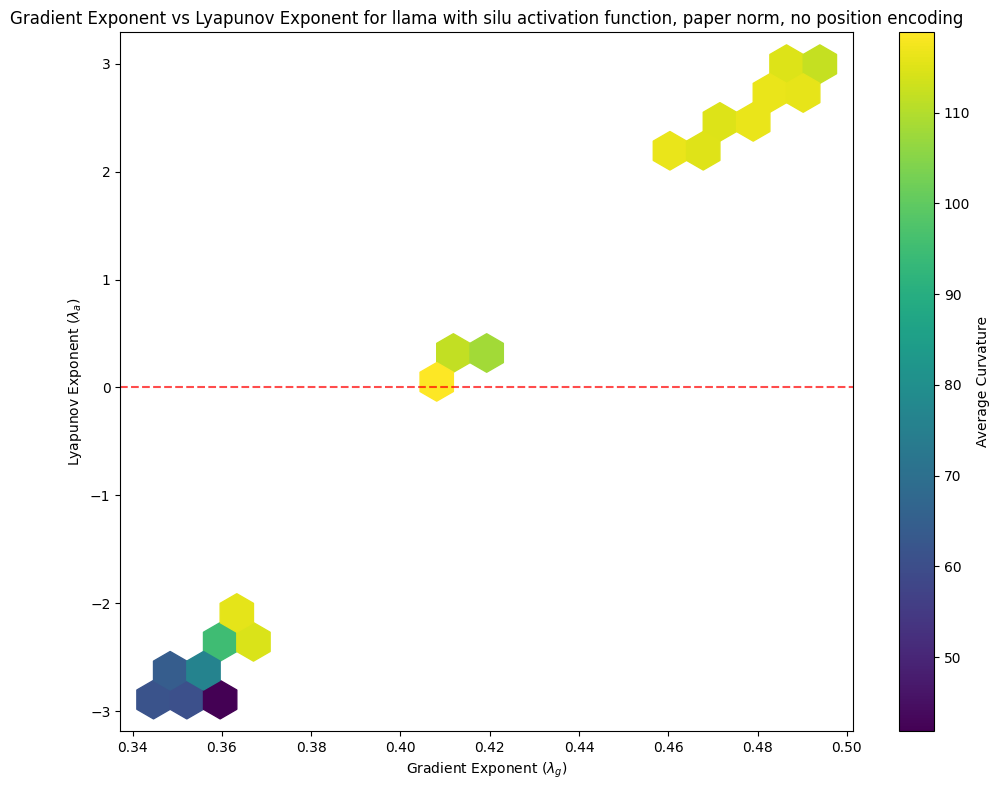

In [40]:
for use_paper_norm in [False, True]:
        for activation_function in ["relu", "tanh", "silu"]:
            for use_position_encoding in [True, False]:
                for model_name in ["llama-small", "gpt2", "llama"]:
                    print("use_paper_norm: ", use_paper_norm)
                    print("activation_function: ", activation_function)
                    print("use_position_encoding: ", use_position_encoding)
                    print("model_name: ", model_name)
                    lyapunov_exponents = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_lyapunov_exponents.npy")
                    gradient_exponents = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_gradient_exponents.npy")
                    curves = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_curves.npy")
                    # plot_curves(curves, lyapunov_exponents, gradient_exponents)
                    try:
                        curves = np.mean(curves, axis=-1)[:, :, 10]
                    except:
                        curves = curves[:, :, 10]
                    create_binned_heatmap(gradient_exponents.flatten(), lyapunov_exponents.flatten(), curves=curves.flatten(), nbins=20, model_name=model_name, activation_function=activation_function, use_paper_norm=use_paper_norm, use_position_encoding=use_position_encoding)
                    # sigmas = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_sigmas.npy")
                    # # Plot gradient exponents
                    # plt.figure(figsize=(10, 8))
                    # plt.subplot(1, 2, 1)
                    # plt.imshow(gradient_exponents)
                    # plt.colorbar(label=r"Gradient Exponent")
                    # #set x and y ticks to be the sigmas
                    # attention_sigmas = sigmas[0, :, 0]
                    # mlp_sigmas = sigmas[:, 0, 1]
                    # plt.xticks(range(0, len(attention_sigmas), 5), np.round(attention_sigmas[::5], 2), rotation=90)
                    # plt.yticks(range(0, len(mlp_sigmas), 5), np.round(mlp_sigmas[::5], 2))
                    # plt.xlabel("Attention Sigma")
                    # plt.ylabel("MLP Sigma")
                    # plt.title("Gradient Exponents for " + model_name)
                    
                    # # Plot lyapunov exponents
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(lyapunov_exponents)
                    # plt.colorbar(label=r"Lyapunov Exponent")
                    # plt.xticks(range(0, len(attention_sigmas), 5), np.round(attention_sigmas[::5], 2), rotation=90)
                    # plt.yticks(range(0, len(mlp_sigmas), 5), np.round(mlp_sigmas[::5], 2))
                    # plt.xlabel("Attention Sigma")
                    # plt.ylabel("MLP Sigma")
                    # plt.title("Lyapunov Exponents for " + model_name)
                    
                    # plt.tight_layout()
                    # plt.show()
                    

In [ ]:
len(np.concatenate([np.arange(0, 4, 0.25), np.arange(0, 15, 0.5)]))

38

In [31]:
67*30

2010

In [30]:
39**2

1521

In [1]:
for use_paper_norm in [False, True]:
    for activation_function in ["relu", "tanh", "silu"]:
        for use_position_encoding in [True, False]:
            for model_name in ["llama-small", "gpt2", "llama"]:
                print("use_paper_norm: ", use_paper_norm)
                print("activation_function: ", activation_function)
                print("use_position_encoding: ", use_position_encoding)
                print("model_name: ", model_name)
                lyapunov_exponents = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_lyapunov_exponents.npy")
                gradient_exponents = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_gradient_exponents.npy")
                curves = np.load(f"/om2/user/jackking/straightening_dynamics/results/{activation_function}/{use_paper_norm}_{use_position_encoding}_{model_name}_curves.npy")
                curves = curves[:, :, 10]
                create_binned_heatmap(gradient_exponents.flatten(), lyapunov_exponents.flatten(), curves=curves.flatten(), nbins=20)
                

use_paper_norm:  False
activation_function:  relu
use_position_encoding:  True
model_name:  llama-small


NameError: name 'np' is not defined

In [11]:
mlp_sigmas = np.arange(0, 5, 0.01)
attention_sigmas = np.arange(0, 10, 0.5)

#find the max lyapunov exponent
max_lyapunov_exponent = np.max(gpt2_lyapunov_exponents)
max_lyapunov_idx = np.unravel_index(np.argmax(gpt2_lyapunov_exponents), gpt2_lyapunov_exponents.shape)
print(f"Max Lyapunov Exponent: {max_lyapunov_exponent}")

#find the max gradient exponent
max_gradient_exponent = np.max(gpt2_gradient_exponents)
print(f"Max Gradient Exponent: {max_gradient_exponent}")
max_gradient_idx = np.unravel_index(np.argmax(gpt2_gradient_exponents), gpt2_gradient_exponents.shape)

#remove the sigmas that give the max lyapunov exponent
gpt2_lyapunov_exponents = np.delete(gpt2_lyapunov_exponents, max_lyapunov_idx, axis=0)
gpt2_gradient_exponents = np.delete(gpt2_gradient_exponents, max_lyapunov_idx, axis=0)
gpt2_curves = np.delete(gpt2_curves, max_lyapunov_idx, axis=0)

#plot the remaining gradient exponent by lyapunov exponent with curve heatmap


Max Lyapunov Exponent: 2.8844342579692124
Max Gradient Exponent: 0.9867960214614868


### see how curvature changes per layer at various points -- to see if there is a good loooking pattern vs a degenerate pattern
### save the exponents in tuples with the sigmas
### look into setting positional embeddings to be 0, 1
### do we want to include the residual addition multipliers
    ### just look into if these are necessary -- maybe just do this for the attention multiplier (from Eghbal)
### maybe use SiLU as the activation function
### verify you can predict exponents from the sigmas
### do individual sigma vs exponent with curvature colored graphs

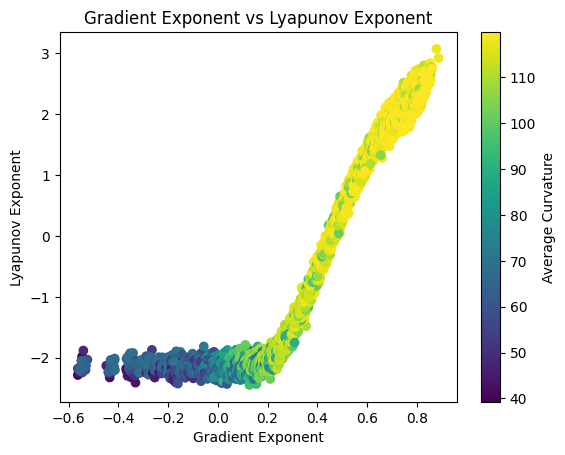

In [5]:
plt.scatter(llama_gradient_exponents.flatten(), llama_lyapunov_exponents.flatten(), c=llama_curves.flatten())
plt.xlabel(r"Gradient Exponent")
plt.ylabel(r"Lyapunov Exponent")
plt.title(r"Gradient Exponent vs Lyapunov Exponent")
plt.colorbar(label=r"Average Curvature")
plt.show()